# Сборный Проект — 2. HR-аналитика

**Основная цель проекта — решить две задачи с использованием машинного обучения:**
1. Построить модель для предсказания уровня удовлетворенности сотрудников работой на основе предоставленных данных.
2. Разработать модель для прогнозирования вероятности увольнения сотрудника из компании.

Проект направлен на помощь HR-аналитикам компании "Работа с заботой" в оптимизации управления персоналом и снижении рисков финансовых потерь, связанных с внезапными увольнениями ключевых сотрудников.

**Описание данных**
Данные содержат характеристики сотрудников компании:
- `id`: уникальный идентификатор сотрудника.
- `dept`: отдел, в котором работает сотрудник.
- `level`: уровень занимаемой должности (junior, middle, senior).
- `workload`: уровень загруженности сотрудника (low, medium, high).
- `employment_years`: длительность работы в компании (в годах).
- `last_year_promo`: факт повышения за последний год (yes/no).
- `last_year_violations`: факт нарушения трудового договора за последний год (yes/no).
- `supervisor_evaluation`: оценка качества работы сотрудника, данная руководителем (от 1 до 5).
- `salary`: ежемесячная зарплата сотрудника.
- `job_satisfaction_rate`: уровень удовлетворенности сотрудника работой (целевой признак для первой задачи, значение от от 0 до 1).
- `quit`: факт увольнения сотрудника из компании (целевой признак для второй задачи, yes/no).

**План работы**
1. **Загрузка данных**:
   - Загрузить тренировочные и тестовые датасеты для обеих задач.
   
   
2. **Предобработка данных**:
   - Проверить наличие пропусков, дубликатов и аномалий.
   - Исправить ошибки в данных (например, заменить опечатки).
   
   
3. **Исследовательский анализ данных**:
   - Визуализировать распределения числовых и категориальных признаков.


4. **Корреляционный анализ**:
    - Провести корреляционный анализ для выявления взаимосвязей между переменными.
   
   
5. **Подготовка данных для моделирования**:
   - Создать пайплайн для обработки различных типов признаков.
   - Добавить новый входной признак (`job_satisfaction_rate`) для второй задачи.
   
   
6. **Обучение моделей**:
   - Обучить модели для решения задачи регрессии: **LinearRegression**, **KNeighborsRegressor**, **DecisionTreeRegressor**.
   - Обучить модели для решения задачи классификации: **LogisticRegression**, **KNeighborsClassifier**, **DecisionTreeClassifier**.
   
   
7. **Оценка результатов**:
   - Вычислить метрику SMAPE для задачи регрессии.
   - Вычислить метрику ROC-AUC для задачи классификации.
   
   
8. **Финальные выводы**:
   - Сформулировать рекомендации для бизнеса на основе анализа данных и результатов моделирования.

In [1]:
!pip install -q phik
!pip install -Uq scikit-learn
!pip install -q shap

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

from sklearn.model_selection import train_test_split, RandomizedSearchCV, GridSearchCV
from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor

from sklearn.metrics import (roc_auc_score, make_scorer)

from sklearn.preprocessing import StandardScaler, MinMaxScaler, OneHotEncoder, OrdinalEncoder, LabelEncoder
from sklearn.impute import SimpleImputer

from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer

from phik import phik_matrix

RANDOM_STATE = 42

## Загрузка данных

**Описание данных**

Данные для выполнения проекта находятся в нескольких таблицах:

- Для первой задачи (предсказание уровня удовлетворенности):


    - `train_js`: содержит все признаки + целевой признак `job_satisfaction_rate`.
    - `X_test_js`: содержит только входные признаки.
    - `y_test_js`: содержит только целевой признак `job_satisfaction_rate`.


- Для второй задачи (предсказание увольнения):


    - `train_q`: содержит все признаки + целевой признак quit.
    - `X_test_q`: содержит только входные признаки (такие же, как в первой задаче).
    - `y_test_q`: содержит только целевой признак quit.

In [3]:
# Загрузка данных для первой задачи
train_js = pd.read_csv('/datasets/train_job_satisfaction_rate.csv')
X_test_js = pd.read_csv('/datasets/test_features.csv')
y_test_js = pd.read_csv('/datasets/test_target_job_satisfaction_rate.csv')

# Загрузка данных для второй задачи
train_q = pd.read_csv('/datasets/train_quit.csv')
y_test_q = pd.read_csv('/datasets/test_target_quit.csv')

# Тестовые признаки для второй задачи совпадают с первой задачей
X_test_q = X_test_js.copy()

In [4]:
# Информация о таблицах
print('Данные для первой задачи:' "\n")
print('train_js: train_job_satisfaction_rate:')
display(train_js.head())
display(train_js.info())
print("=" * 40 + "\n")

print('X_test_js: test_features:')
display(X_test_js.head(6))
display(X_test_js.info())
print("=" * 40 + "\n")

print('y_test_js: test_target_job_satisfaction_rate:')
display(y_test_js.head())
display(y_test_js.info())
print("=" * 40 + "\n")

print('train_q: Данные для второй задачи:' "\n")
print('train_quit:')
display(train_q.head())
display(train_q.info())
print("=" * 40 + "\n")
      
print('X_test_q: test_features:')
display(X_test_q.head(6))
display(X_test_q.info())
print("=" * 40 + "\n")

print('y_test_q: test_target_quit:')
display(y_test_q.head())
display(y_test_q.info())
print("=" * 40 + "\n")

Данные для первой задачи:

train_js: train_job_satisfaction_rate:


id        dept   level workload  employment_years last_year_promo  \
0  155278       sales  junior   medium                 2              no   
1  653870          hr  junior     high                 2              no   
2  184592       sales  junior      low                 1              no   
3  171431  technology  junior      low                 4              no   
4  693419          hr  junior   medium                 1              no   

  last_year_violations  supervisor_evaluation  salary  job_satisfaction_rate  
0                   no                      1   24000                   0.58  
1                   no                      5   38400                   0.76  
2                   no                      2   12000                   0.11  
3                   no                      2   18000                   0.37  
4                   no                      3   22800                   0.20

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4000 entries, 0 to 3999
Data columns (total 10 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   id                     4000 non-null   int64  
 1   dept                   3994 non-null   object 
 2   level                  3996 non-null   object 
 3   workload               4000 non-null   object 
 4   employment_years       4000 non-null   int64  
 5   last_year_promo        4000 non-null   object 
 6   last_year_violations   4000 non-null   object 
 7   supervisor_evaluation  4000 non-null   int64  
 8   salary                 4000 non-null   int64  
 9   job_satisfaction_rate  4000 non-null   float64
dtypes: float64(1), int64(4), object(5)
memory usage: 312.6+ KB


None


X_test_js: test_features:


id        dept   level workload  employment_years last_year_promo  \
0  485046   marketing  junior   medium                 2              no   
1  686555          hr  junior   medium                 1              no   
2  467458       sales  middle      low                 5              no   
3  418655       sales  middle      low                 6              no   
4  789145          hr  middle   medium                 5              no   
5  429973  purchasing  middle   medium                 6              no   

  last_year_violations  supervisor_evaluation  salary  
0                   no                      5   28800  
1                   no                      4   30000  
2                   no                      4   19200  
3                   no                      4   19200  
4                   no                      5   40800  
5                   no                      3   42000

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data columns (total 9 columns):
 #   Column                 Non-Null Count  Dtype 
---  ------                 --------------  ----- 
 0   id                     2000 non-null   int64 
 1   dept                   1998 non-null   object
 2   level                  1999 non-null   object
 3   workload               2000 non-null   object
 4   employment_years       2000 non-null   int64 
 5   last_year_promo        2000 non-null   object
 6   last_year_violations   2000 non-null   object
 7   supervisor_evaluation  2000 non-null   int64 
 8   salary                 2000 non-null   int64 
dtypes: int64(4), object(5)
memory usage: 140.8+ KB


None


y_test_js: test_target_job_satisfaction_rate:


id  job_satisfaction_rate
0  130604                   0.74
1  825977                   0.75
2  418490                   0.60
3  555320                   0.72
4  826430                   0.08

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data columns (total 2 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   id                     2000 non-null   int64  
 1   job_satisfaction_rate  2000 non-null   float64
dtypes: float64(1), int64(1)
memory usage: 31.4 KB


None


train_q: Данные для второй задачи:

train_quit:


id        dept   level workload  employment_years last_year_promo  \
0  723290       sales  middle     high                 2              no   
1  814010       sales  junior   medium                 2              no   
2  155091  purchasing  middle   medium                 5              no   
3  257132       sales  junior   medium                 2              no   
4  910140   marketing  junior   medium                 2              no   

  last_year_violations  supervisor_evaluation  salary quit  
0                   no                      4   54000   no  
1                   no                      4   27600   no  
2                   no                      1   37200   no  
3                  yes                      3   24000  yes  
4                   no                      5   25200   no

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4000 entries, 0 to 3999
Data columns (total 10 columns):
 #   Column                 Non-Null Count  Dtype 
---  ------                 --------------  ----- 
 0   id                     4000 non-null   int64 
 1   dept                   4000 non-null   object
 2   level                  4000 non-null   object
 3   workload               4000 non-null   object
 4   employment_years       4000 non-null   int64 
 5   last_year_promo        4000 non-null   object
 6   last_year_violations   4000 non-null   object
 7   supervisor_evaluation  4000 non-null   int64 
 8   salary                 4000 non-null   int64 
 9   quit                   4000 non-null   object
dtypes: int64(4), object(6)
memory usage: 312.6+ KB


None


X_test_q: test_features:


id        dept   level workload  employment_years last_year_promo  \
0  485046   marketing  junior   medium                 2              no   
1  686555          hr  junior   medium                 1              no   
2  467458       sales  middle      low                 5              no   
3  418655       sales  middle      low                 6              no   
4  789145          hr  middle   medium                 5              no   
5  429973  purchasing  middle   medium                 6              no   

  last_year_violations  supervisor_evaluation  salary  
0                   no                      5   28800  
1                   no                      4   30000  
2                   no                      4   19200  
3                   no                      4   19200  
4                   no                      5   40800  
5                   no                      3   42000

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data columns (total 9 columns):
 #   Column                 Non-Null Count  Dtype 
---  ------                 --------------  ----- 
 0   id                     2000 non-null   int64 
 1   dept                   1998 non-null   object
 2   level                  1999 non-null   object
 3   workload               2000 non-null   object
 4   employment_years       2000 non-null   int64 
 5   last_year_promo        2000 non-null   object
 6   last_year_violations   2000 non-null   object
 7   supervisor_evaluation  2000 non-null   int64 
 8   salary                 2000 non-null   int64 
dtypes: int64(4), object(5)
memory usage: 140.8+ KB


None


y_test_q: test_target_quit:


id quit
0  999029  yes
1  372846   no
2  726767   no
3  490105   no
4  416898  yes

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   id      2000 non-null   int64 
 1   quit    2000 non-null   object
dtypes: int64(1), object(1)
memory usage: 31.4+ KB


None

- Всего в датасете `train_js` 10 столбцов и 4000 строк. При первичном анализе обнаружены пропуски в столбцах: `dept` и `level`.
- Всего в датасете `X_test_js` 9 столбцов и 2000 строк. При первичном анализе обнаружены пропуски в столбцах: `dept` и `level`.
- Всего в датасете `y_test_js` 2 столбцов и 2000 строк. При первичном анализе пропущенных значений не обнаружено.


- Всего в датасете `train_q` 10 столбцов и 4000 строк. При первичном анализе пропущенных значений не обнаружено.
- Всего в датасете `X_test_q` 9 столбцов и 2000 строк. При первичном анализе обнаружены пропуски в столбцах: `dept` и `level`.
- Всего в датасете `y_test_q` 2 столбцов и 2000 строк. При первичном анализе пропущенных значений не обнаружено.

## Предобработка данных

Используем функцию `check_data` для предварительного ознакомления с данными и их обработки.

In [5]:
def check_data(data, bins=10, figsize=(15, 8)):
    print('Первые строки данных:')
    display(data.head())

    print('\nПоследние строки данных:')
    display(data.tail())

    print('\nРазмерность данных:')
    display(data.shape)

    print('\nИнформация о типах данных и пропусках:')
    display(data.info())

    # Анализ пропусков
    print('\nПропуски (количество и доля):')
    total_missing = data.isnull().sum().sort_values(ascending=False)
    percent_missing = (data.isnull().sum() / data.shape[0]).sort_values(ascending=False)
    missing_data = pd.concat([total_missing, percent_missing], axis=1, keys=['total', 'percent'])

    # Проверяем, есть ли пропуски
    if missing_data['total'].sum() > 0:
        print(missing_data[missing_data['total'] > 0])  # Вывод только столбцов с пропусками
    else:
        print('Пропуски отсутствуют в данных.')

    # Анализ количественных столбцов
    numeric_columns = data.select_dtypes(include=['number']).columns
    numeric_columns = numeric_columns[numeric_columns != 'id']  # Исключаем столбец 'id'
    
    # Разделение на дискретные и непрерывные
    discrete_columns = []
    continuous_columns = []
    for col in numeric_columns:
        if data[col].nunique() < 20:  # Пороговое значение для определения дискретности
            discrete_columns.append(col)
        else:
            continuous_columns.append(col)
    
    # Построение гистограмм для непрерывных столбцов
    if continuous_columns:  # Проверка на наличие числового столбца
        print('\nГрафики распределения для количественных непрерывных столбцов (гистограммы):')
        # Определяем количество строк и столбцов для подграфиков
        n_cols = 2
        n_rows = (len(continuous_columns) + n_cols - 1) // n_cols
        
        fig, axes = plt.subplots(n_rows, n_cols, figsize=figsize)
        axes = axes.flatten()
        
        for i, col in enumerate(continuous_columns):
            axes[i].hist(data[col], bins=bins, color='blue')
            axes[i].grid(True)
            axes[i].set_title(f'Распределение для {col}')
            axes[i].set_xlabel(col)
            axes[i].set_ylabel('Количество')
        
        # Убираем пустые подграфики, если они есть
        for j in range(i + 1, len(axes)):
            fig.delaxes(axes[j])
        
        plt.tight_layout() # Автоматически подгоняет подграфики
        plt.show()
    
    # Построение столбиковых диаграмм для дискретных столбцов
    if discrete_columns:  # Проверка на наличие числового столбца
        print('\nГрафики распределения для количественных дискретных столбцов (столбчатые диаграммы):')
        # Определяем количество строк и столбцов для подграфиков
        n_cols = 2
        n_rows = (len(discrete_columns) + n_cols - 1) // n_cols
        
        fig, axes = plt.subplots(n_rows, n_cols, figsize=figsize)
        axes = axes.flatten()  # Создаем одномерный массив
        
        for i, col in enumerate(discrete_columns):
            value_counts = data[col].value_counts().sort_index()
            axes[i].bar(value_counts.index, value_counts.values, color='green')
            axes[i].grid(True)            
            axes[i].set_title(f'Распределение для {col}')
            axes[i].set_xlabel(col)
            axes[i].set_ylabel('Количество')
        
        # Убираем пустые подграфики, если они есть
        for j in range(i + 1, len(axes)):
            fig.delaxes(axes[j])
        
        plt.tight_layout() # Автоматически подгоняет подграфики
        plt.show()

    # Анализ категориальных столбцов
    categorical_columns = data.select_dtypes(exclude=['number']).columns
    if not categorical_columns.empty:
        print('\nУникальные значения для категориальных столбцов:')
        for col in categorical_columns:
            print(f'\nСтолбец: {col}')
            print(data[col].value_counts())
            print(f'Количество уникальных значений: {data[col].nunique()}')
            
    # Проверка на дубликаты
    duplicate_rows = data.duplicated().sum()
    
    if duplicate_rows > 0:
        print(f"\nОбнаружено {duplicate_rows} дубликатов в данных.")
        print("Дубликаты:")
        display(data[data.duplicated()])
    else:
        print("\nДубликаты отсутствуют в данных.")

### Задача 1 - Предобработка данных

Предобработку начнем с первой задачи.

**Рассмотрим `train_js`**.

In [6]:
train_js.describe()

id  employment_years  supervisor_evaluation        salary  \
count    4000.000000       4000.000000            4000.000000   4000.000000   
mean   544957.621000          3.718500               3.476500  33926.700000   
std    257883.104622          2.542513               1.008812  14900.703838   
min    100954.000000          1.000000               1.000000  12000.000000   
25%    322836.750000          2.000000               3.000000  22800.000000   
50%    534082.500000          3.000000               4.000000  30000.000000   
75%    771446.000000          6.000000               4.000000  43200.000000   
max    999521.000000         10.000000               5.000000  98400.000000   

       job_satisfaction_rate  
count            4000.000000  
mean                0.533995  
std                 0.225327  
min                 0.030000  
25%                 0.360000  
50%                 0.560000  
75%                 0.710000  
max                 1.000000

Первые строки данных:


id        dept   level workload  employment_years last_year_promo  \
0  155278       sales  junior   medium                 2              no   
1  653870          hr  junior     high                 2              no   
2  184592       sales  junior      low                 1              no   
3  171431  technology  junior      low                 4              no   
4  693419          hr  junior   medium                 1              no   

  last_year_violations  supervisor_evaluation  salary  job_satisfaction_rate  
0                   no                      1   24000                   0.58  
1                   no                      5   38400                   0.76  
2                   no                      2   12000                   0.11  
3                   no                      2   18000                   0.37  
4                   no                      3   22800                   0.20


Последние строки данных:


id        dept   level workload  employment_years last_year_promo  \
3995  457950  technology  junior     high                 2              no   
3996  957499       sales  junior   medium                 2              no   
3997  533318       sales  middle      low                 7              no   
3998  706868       sales  junior   medium                 2              no   
3999  338347  technology  middle   medium                 5              no   

     last_year_violations  supervisor_evaluation  salary  \
3995                   no                      3   46800   
3996                   no                      4   21600   
3997                   no                      5   24000   
3998                   no                      3   24000   
3999                  yes                      1   44400   

      job_satisfaction_rate  
3995                   0.45  
3996                   0.68  
3997                   0.76  
3998                   0.48  
3999                   0.18


Размерность данных:


(4000, 10)


Информация о типах данных и пропусках:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4000 entries, 0 to 3999
Data columns (total 10 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   id                     4000 non-null   int64  
 1   dept                   3994 non-null   object 
 2   level                  3996 non-null   object 
 3   workload               4000 non-null   object 
 4   employment_years       4000 non-null   int64  
 5   last_year_promo        4000 non-null   object 
 6   last_year_violations   4000 non-null   object 
 7   supervisor_evaluation  4000 non-null   int64  
 8   salary                 4000 non-null   int64  
 9   job_satisfaction_rate  4000 non-null   float64
dtypes: float64(1), int64(4), object(5)
memory usage: 312.6+ KB


None


Пропуски (количество и доля):
       total  percent
dept       6   0.0015
level      4   0.0010

Графики распределения для количественных непрерывных столбцов (гистограммы):


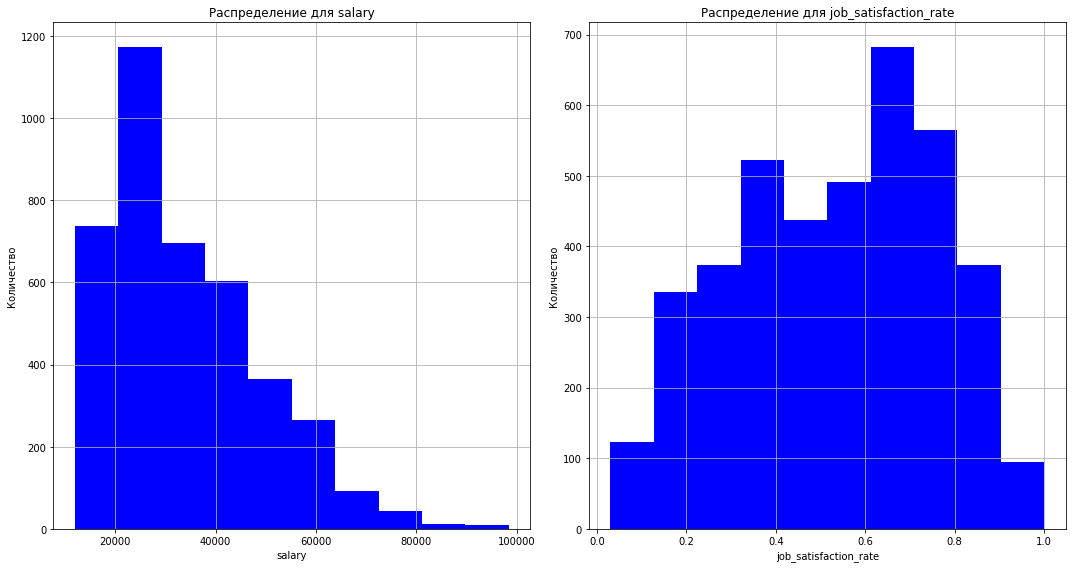


Графики распределения для количественных дискретных столбцов (столбчатые диаграммы):


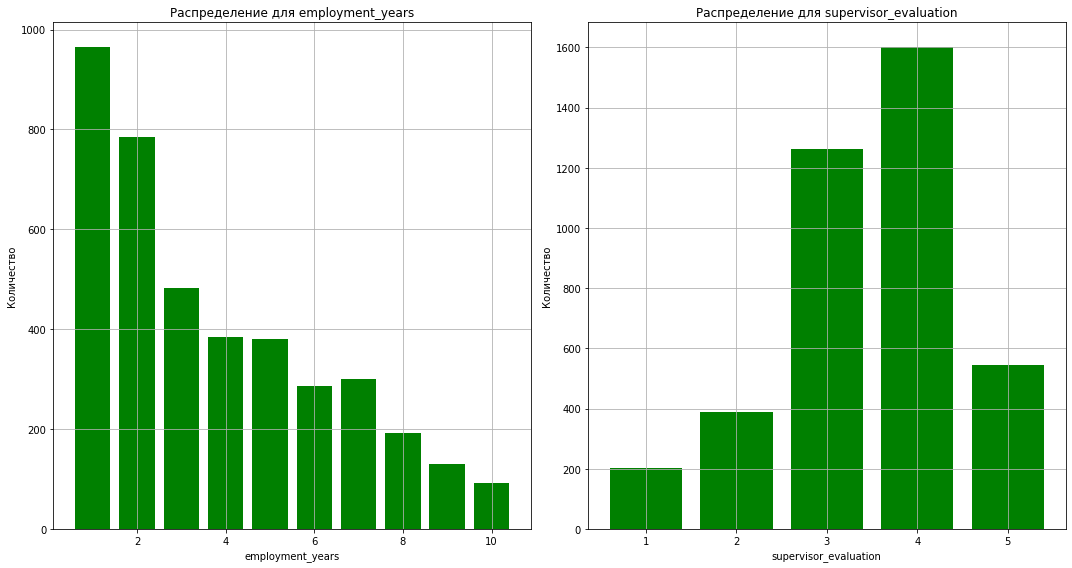


Уникальные значения для категориальных столбцов:

Столбец: dept
sales         1512
technology     866
purchasing     610
marketing      550
hr             456
Name: dept, dtype: int64
Количество уникальных значений: 5

Столбец: level
junior    1894
middle    1744
sinior     358
Name: level, dtype: int64
Количество уникальных значений: 3

Столбец: workload
medium    2066
low       1200
high       734
Name: workload, dtype: int64
Количество уникальных значений: 3

Столбец: last_year_promo
no     3880
yes     120
Name: last_year_promo, dtype: int64
Количество уникальных значений: 2

Столбец: last_year_violations
no     3441
yes     559
Name: last_year_violations, dtype: int64
Количество уникальных значений: 2

Дубликаты отсутствуют в данных.


In [7]:
check_data(train_js)

Типы данных в датасете соответсвуют данным.

Определим все строки с пропущеными значениями в `train_js`

In [8]:
# Выведем все строки с пропущенными значениями в датасете
train_js[train_js['dept'].isnull() | train_js['level'].isnull()]

id   dept   level workload  employment_years last_year_promo  \
1209  631073  sales     NaN   medium                 1              no   
1469  416327  sales     NaN      low                 1              no   
1526  694746    NaN  junior   medium                 5              no   
1630  814624    NaN  junior   medium                 3              no   
1633  475114    NaN  junior     high                 4              no   
1745  135043  sales     NaN   medium                 1              no   
2522  998838  sales     NaN   medium                 1              no   
2781  497243    NaN  junior   medium                 1              no   
2975  168668    NaN  junior      low                 3              no   
3866  641150    NaN  junior      low                 3              no   

     last_year_violations  supervisor_evaluation  salary  \
1209                   no                      4   27600   
1469                   no                      5   18000   
1526                   no                      4   21600   
1630                   no                      4   24000   
1633                   no                      4   31200   
1745                   no                      3   26400   
2522                   no                      5   27600   
2781                   no                      3   26400   
2975                   no                      4   18000   
3866                  yes                      4   12000   

      job_satisfaction_rate  
1209                   0.66  
1469                   0.73  
1526                   0.62  
1630                   0.88  
1633                   0.63  
1745                   0.30  
2522                   0.71  
2781                   0.28  
2975                   0.88  
3866                   0.54

Пропуски в столбцах `dept` и `level`, будут заполнены в пайплайне при обучении модели.

В столбце `level` обнаружна отпечатка `sinior`, заменим на `senior`.

In [9]:
# Устраним отпечатку
train_js['level'] = train_js['level'].replace('sinior', 'senior')
train_js['level'].value_counts()

junior    1894
middle    1744
senior     358
Name: level, dtype: int64

---

**Рассмотрим `X_test_js`**.

Первые строки данных:


id       dept   level workload  employment_years last_year_promo  \
0  485046  marketing  junior   medium                 2              no   
1  686555         hr  junior   medium                 1              no   
2  467458      sales  middle      low                 5              no   
3  418655      sales  middle      low                 6              no   
4  789145         hr  middle   medium                 5              no   

  last_year_violations  supervisor_evaluation  salary  
0                   no                      5   28800  
1                   no                      4   30000  
2                   no                      4   19200  
3                   no                      4   19200  
4                   no                      5   40800


Последние строки данных:


id        dept   level workload  employment_years last_year_promo  \
1995  393147   marketing  junior      low                 3              no   
1996  109582  technology  middle      low                 3              no   
1997  305653  technology  junior      low                 1              no   
1998  160233  technology  middle      low                 8              no   
1999  771859  purchasing  middle   medium                 1              no   

     last_year_violations  supervisor_evaluation  salary  
1995                   no                      3   20400  
1996                   no                      2   21600  
1997                   no                      3   14400  
1998                   no                      1   32400  
1999                   no                      4   38400


Размерность данных:


(2000, 9)


Информация о типах данных и пропусках:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data columns (total 9 columns):
 #   Column                 Non-Null Count  Dtype 
---  ------                 --------------  ----- 
 0   id                     2000 non-null   int64 
 1   dept                   1998 non-null   object
 2   level                  1999 non-null   object
 3   workload               2000 non-null   object
 4   employment_years       2000 non-null   int64 
 5   last_year_promo        2000 non-null   object
 6   last_year_violations   2000 non-null   object
 7   supervisor_evaluation  2000 non-null   int64 
 8   salary                 2000 non-null   int64 
dtypes: int64(4), object(5)
memory usage: 140.8+ KB


None


Пропуски (количество и доля):
       total  percent
dept       2   0.0010
level      1   0.0005

Графики распределения для количественных непрерывных столбцов (гистограммы):


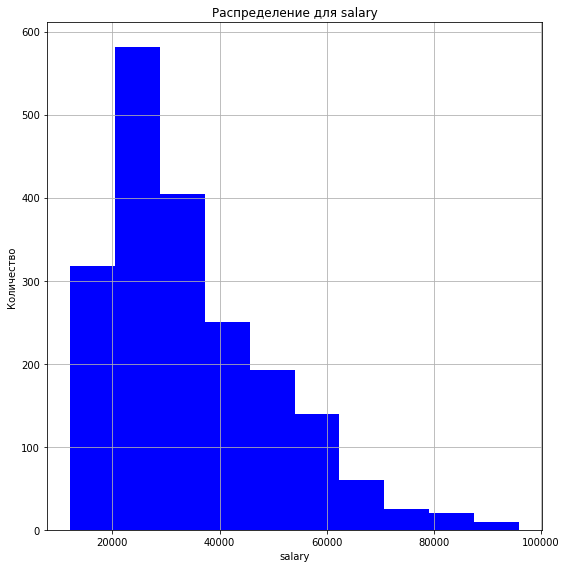


Графики распределения для количественных дискретных столбцов (столбчатые диаграммы):


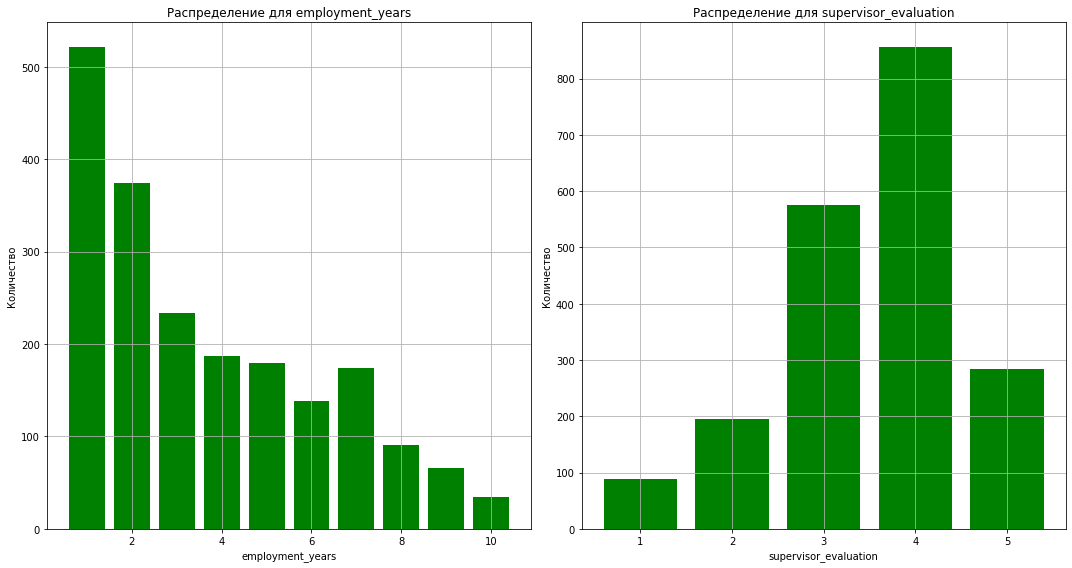


Уникальные значения для категориальных столбцов:

Столбец: dept
sales         763
technology    455
marketing     279
purchasing    273
hr            227
                1
Name: dept, dtype: int64
Количество уникальных значений: 6

Столбец: level
junior    974
middle    854
sinior    171
Name: level, dtype: int64
Количество уникальных значений: 3

Столбец: workload
medium    1043
low        593
high       363
             1
Name: workload, dtype: int64
Количество уникальных значений: 4

Столбец: last_year_promo
no     1937
yes      63
Name: last_year_promo, dtype: int64
Количество уникальных значений: 2

Столбец: last_year_violations
no     1738
yes     262
Name: last_year_violations, dtype: int64
Количество уникальных значений: 2

Дубликаты отсутствуют в данных.


In [10]:
check_data(X_test_js)

Типы данных в датасете соответсвуют данным.

Определим все строки с пропущеными значениями в `X_test_js`

In [11]:
# Выведем все строки с пропущенными значениями в датасете
X_test_js[X_test_js['dept'].isnull() | X_test_js['level'].isnull()]

id   dept   level workload  employment_years last_year_promo  \
191   609865    NaN  junior   medium                 1              no   
312   471990  sales     NaN      low                 1              no   
1196  832342    NaN  junior   medium                 1              no   

     last_year_violations  supervisor_evaluation  salary  
191                    no                      1   20400  
312                    no                      3   12000  
1196                   no                      4   28800

В столбце `dept`, `workload` также обнаружен строковые пропуски.

In [12]:
X_test_js['dept'].value_counts()

sales         763
technology    455
marketing     279
purchasing    273
hr            227
                1
Name: dept, dtype: int64

In [13]:
X_test_js['workload'].value_counts()

medium    1043
low        593
high       363
             1
Name: workload, dtype: int64

Переведем их в пропуски типа `np.nan`.

In [14]:
X_test_js['dept'] = X_test_js['dept'].replace(' ', np.nan)
X_test_js['dept'].value_counts()

sales         763
technology    455
marketing     279
purchasing    273
hr            227
Name: dept, dtype: int64

In [15]:
X_test_js['workload'] = X_test_js['workload'].replace(' ', np.nan)
X_test_js['workload'].value_counts()

medium    1043
low        593
high       363
Name: workload, dtype: int64

Отоброзим пропуски в таблице `X_test_js` повторно.

In [16]:
display(X_test_js.isnull().sum())
print('=' * 40)
X_test_js.info()

id                       0
dept                     3
level                    1
workload                 1
employment_years         0
last_year_promo          0
last_year_violations     0
supervisor_evaluation    0
salary                   0
dtype: int64

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data columns (total 9 columns):
 #   Column                 Non-Null Count  Dtype 
---  ------                 --------------  ----- 
 0   id                     2000 non-null   int64 
 1   dept                   1997 non-null   object
 2   level                  1999 non-null   object
 3   workload               1999 non-null   object
 4   employment_years       2000 non-null   int64 
 5   last_year_promo        2000 non-null   object
 6   last_year_violations   2000 non-null   object
 7   supervisor_evaluation  2000 non-null   int64 
 8   salary                 2000 non-null   int64 
dtypes: int64(4), object(5)
memory usage: 140.8+ KB


Пропуски в столбцах `dept`, `level` и `workload`, будут заполнены в пайплайне при обучении модели.

---

**Рассмотрим `y_test_js`**.

Первые строки данных:


id  job_satisfaction_rate
0  130604                   0.74
1  825977                   0.75
2  418490                   0.60
3  555320                   0.72
4  826430                   0.08


Последние строки данных:


id  job_satisfaction_rate
1995  405257                   0.28
1996  370925                   0.21
1997  857722                   0.39
1998  303402                   0.26
1999  648995                   0.62


Размерность данных:


(2000, 2)


Информация о типах данных и пропусках:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data columns (total 2 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   id                     2000 non-null   int64  
 1   job_satisfaction_rate  2000 non-null   float64
dtypes: float64(1), int64(1)
memory usage: 31.4 KB


None


Пропуски (количество и доля):
Пропуски отсутствуют в данных.

Графики распределения для количественных непрерывных столбцов (гистограммы):


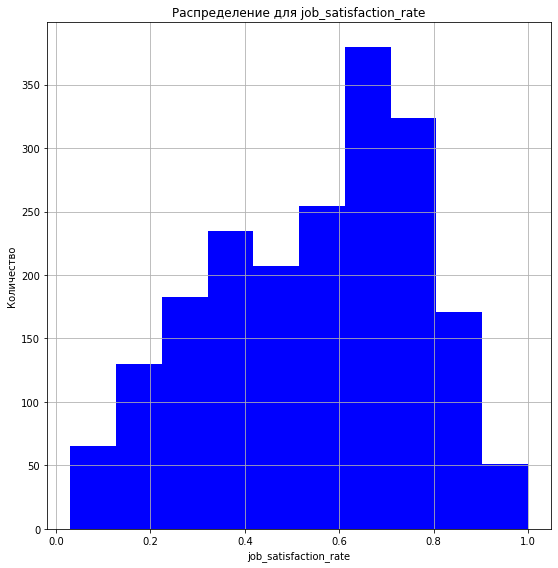


Дубликаты отсутствуют в данных.


In [17]:
check_data(y_test_js)

Всего в датасете 2000 записей. Пропущенных значений не обнаружено.

### Задача 2 - Предобработка данных

Начнем предобработку данных для второй задачи.

**Рассмотрим `train_q`**.

Первые строки данных:


id        dept   level workload  employment_years last_year_promo  \
0  723290       sales  middle     high                 2              no   
1  814010       sales  junior   medium                 2              no   
2  155091  purchasing  middle   medium                 5              no   
3  257132       sales  junior   medium                 2              no   
4  910140   marketing  junior   medium                 2              no   

  last_year_violations  supervisor_evaluation  salary quit  
0                   no                      4   54000   no  
1                   no                      4   27600   no  
2                   no                      1   37200   no  
3                  yes                      3   24000  yes  
4                   no                      5   25200   no


Последние строки данных:


id        dept   level workload  employment_years last_year_promo  \
3995  588809       sales  junior   medium                 4              no   
3996  672059       sales  middle     high                 9              no   
3997  536432  purchasing  junior      low                 2              no   
3998  692133  purchasing  middle   medium                 2              no   
3999  853842       sales  junior   medium                 2              no   

     last_year_violations  supervisor_evaluation  salary quit  
3995                   no                      3   26400   no  
3996                   no                      4   52800   no  
3997                  yes                      4   12000  yes  
3998                   no                      4   33600   no  
3999                   no                      3   27600  yes


Размерность данных:


(4000, 10)


Информация о типах данных и пропусках:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4000 entries, 0 to 3999
Data columns (total 10 columns):
 #   Column                 Non-Null Count  Dtype 
---  ------                 --------------  ----- 
 0   id                     4000 non-null   int64 
 1   dept                   4000 non-null   object
 2   level                  4000 non-null   object
 3   workload               4000 non-null   object
 4   employment_years       4000 non-null   int64 
 5   last_year_promo        4000 non-null   object
 6   last_year_violations   4000 non-null   object
 7   supervisor_evaluation  4000 non-null   int64 
 8   salary                 4000 non-null   int64 
 9   quit                   4000 non-null   object
dtypes: int64(4), object(6)
memory usage: 312.6+ KB


None


Пропуски (количество и доля):
Пропуски отсутствуют в данных.

Графики распределения для количественных непрерывных столбцов (гистограммы):


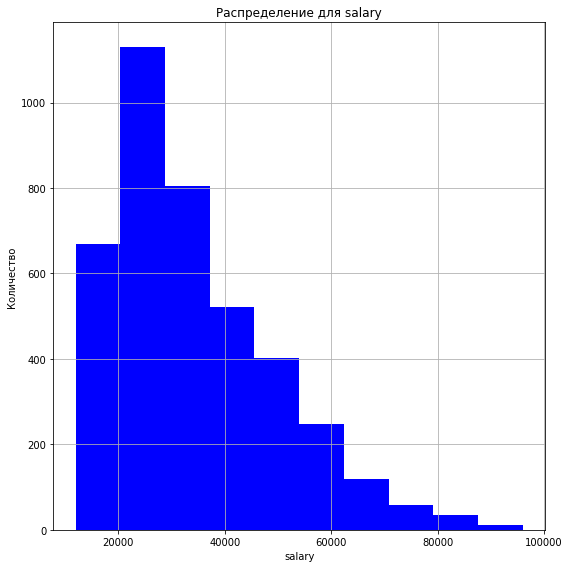


Графики распределения для количественных дискретных столбцов (столбчатые диаграммы):


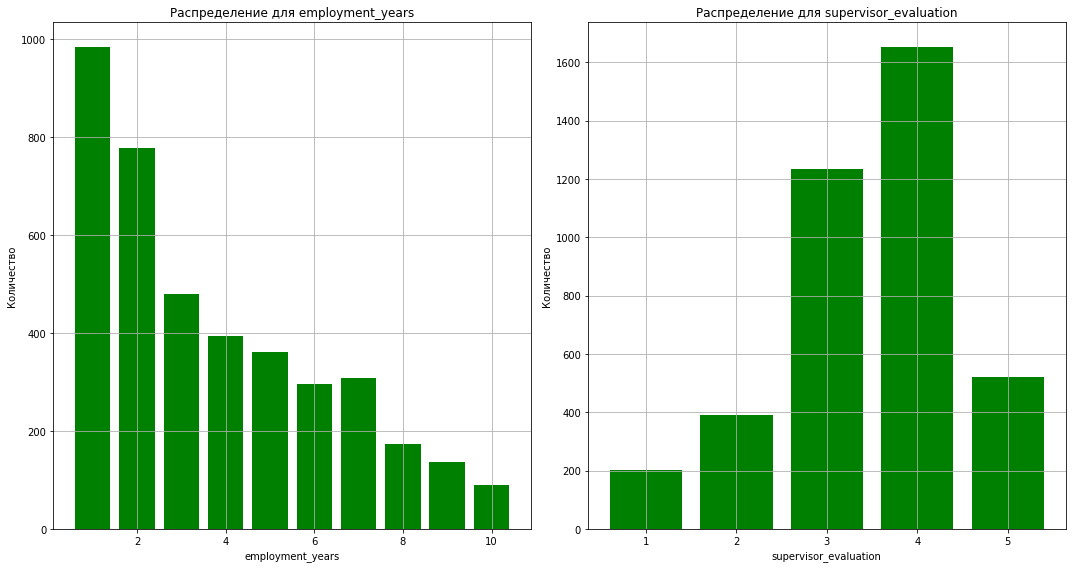


Уникальные значения для категориальных столбцов:

Столбец: dept
sales         1438
technology     928
purchasing     588
marketing      582
hr             464
Name: dept, dtype: int64
Количество уникальных значений: 5

Столбец: level
junior    1949
middle    1694
sinior     357
Name: level, dtype: int64
Количество уникальных значений: 3

Столбец: workload
medium    2118
low       1208
high       674
Name: workload, dtype: int64
Количество уникальных значений: 3

Столбец: last_year_promo
no     3887
yes     113
Name: last_year_promo, dtype: int64
Количество уникальных значений: 2

Столбец: last_year_violations
no     3455
yes     545
Name: last_year_violations, dtype: int64
Количество уникальных значений: 2

Столбец: quit
no     2872
yes    1128
Name: quit, dtype: int64
Количество уникальных значений: 2

Дубликаты отсутствуют в данных.


In [18]:
check_data(train_q)

Типы данных в датасете соответсвуют данным.

В столбце `level` обнаружна отпечатка `sinior`, заменим на `senior`.

In [19]:
# Устраним отпечатку
train_q['level'] = train_q['level'].replace('sinior', 'senior')
train_q['level'].value_counts()

junior    1949
middle    1694
senior     357
Name: level, dtype: int64

---

**Рассмотрим `X_test_q`**.

In [20]:
X_test_q = X_test_js.copy()

Данные аналогичны по содержанию, как в первой задаче.

---

**Рассмотрим `y_test_q`**.

In [21]:
check_data(y_test_q)

Первые строки данных:


id quit
0  999029  yes
1  372846   no
2  726767   no
3  490105   no
4  416898  yes


Последние строки данных:


id quit
1995  836109  yes
1996  180999  yes
1997  746018   no
1998  247658   no
1999  460332  yes


Размерность данных:


(2000, 2)


Информация о типах данных и пропусках:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   id      2000 non-null   int64 
 1   quit    2000 non-null   object
dtypes: int64(1), object(1)
memory usage: 31.4+ KB


None


Пропуски (количество и доля):
Пропуски отсутствуют в данных.

Уникальные значения для категориальных столбцов:

Столбец: quit
no     1436
yes     564
Name: quit, dtype: int64
Количество уникальных значений: 2

Дубликаты отсутствуют в данных.


Типы данных в датасете соответсвуют данным.

> **Промежуточный итог**:
>
> На этапе предобработки данных были выполнены все необходимые шаги для подготовки данных к анализу:
>
> **Для первой задачи:**
>    - **train_js:**
>      
>    Всего в датасете 4000 строк и 10 столбцов.
>    В столбце `level` обнаружна отпечатка `sinior`, замена на `senior`.
>    Есть пропущенные значения в столбцах `dept - 6` и `level - 4`.
>    Явные дубликаты и неявные не обнаружены.
>    Типы данных в датасете соответсвуют.
>
>
>    - **X_test_js:**
>      
>    Всего в датасете 2000 строк и 9 столбцов.
>    Есть пропущенные значения в столбцах `dept - 3`, `level - 1` и `workload - 1`.
>    Явные дубликаты и неявные не обнаружены.
>    Типы данных в датасете соответсвуют.
>
>
>    - **y_test_js:**
>      
>    Всего в датасете 2000 строк и 2 столбцов.
>    Пропущенные значения в столбцах отсуствуют.
>    Явные дубликаты и неявные не обнаружены.
>    Типы данных в датасете соответсвуют.
>
> **Для второй задачи:**
>    - **train_q:**
>      
>    Всего в датасете 4000 строк и 10 столбцов.
>    В столбце `level` обнаружна отпечатка `sinior`, замена на `senior`.
>    Пропуски отсутствуют в данных.
>    Явные дубликаты и неявные не обнаружены.
>    Типы данных в датасете соответсвуют.
>
>
>    - **X_test_q:**
>      
>    Всего в датасете 2000 строк и 9 столбцов.
>    Есть пропущенные значения в столбцах `dept - 3`, `level - 1` и `workload - 1`.
>    Явные дубликаты и неявные не обнаружены.
>    Типы данных в датасете соответсвуют.
>
>
>    - **y_test_q:**
>      
>    Всего в датасете 2000 строк и 2 столбцов.
>    Пропущенные значения в столбцах отсуствуют.
>    Явные дубликаты и неявные не обнаружены.
>    Типы данных в датасете соответсвуют данным.

## Исследовательский анализ данных

Для исследовательского анализа будем использовать функцию для анализа количественных признаков и категориальных признаков.

In [22]:
def number_columns(data, column, bins=50):
    
    # Описательная статистика
    description = data[column].describe()
    print(f"\n=== Описательная статистика для '{column}' ===")
    print(description)
    
    # Проверка на выбросы с использованием IQR
    Q1 = data[column].quantile(0.25)
    Q3 = data[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    
    outliers = data[(data[column] < lower_bound) | (data[column] > upper_bound)]
    print(f"\nКоличество выбросов в '{column}': {len(outliers)}")
    
    # Построение гистограммы и boxplot
    fig, ax = plt.subplots(1, 2, figsize=(15, 6))
    
    sns.histplot(x=data[column], kde=True, ax=ax[0], bins=bins, color='skyblue')
    ax[0].set_title(f'Гистограмма для {column}')
    ax[0].set_xlabel(column)
    ax[0].set_ylabel('Частота')
    
    sns.boxplot(x=data[column], ax=ax[1], color='lightgreen')
    ax[1].set_title(f'Boxplot для {column}')
    ax[1].set_xlabel(column)
    
    plt.tight_layout()
    plt.show()

In [23]:
# Выделим функцию для построения графиков
def plot_number_columns(data, column, bins=50):
    
    # Построение гистограммы и boxplot
    fig, ax = plt.subplots(1, 2, figsize=(15, 6))
    
    sns.histplot(x=data[column], kde=True, ax=ax[0], bins=bins, color='skyblue')
    ax[0].set_title(f'Гистограмма для {column}')
    ax[0].set_xlabel(column)
    ax[0].set_ylabel('Частота')
    
    sns.boxplot(x=data[column], ax=ax[1], color='lightgreen')
    ax[1].set_title(f'Boxplot для {column}')
    ax[1].set_xlabel(column)
    
    plt.tight_layout()
    plt.show()

In [24]:
# Функция для исследовательского анализа дискретных количественных признаков
def discrete_columns(data, column):
    # Описательная статистика
    description = data[column].describe()
    print(f"\n=== Описательная статистика для '{column}' ===")
    print(description)
    
    # Проверка на выбросы с использованием IQR
    Q1 = data[column].quantile(0.25)
    Q3 = data[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    
    outliers = data[(data[column] < lower_bound) | (data[column] > upper_bound)]
    print(f"\nКоличество выбросов в '{column}': {len(outliers)}")
    
    # Построение графиков на одном полотне
    fig, axes = plt.subplots(1, 2, figsize=(15, 6))
    
    # Столбчатая диаграмма
    value_counts = data[column].value_counts().sort_index()
    sns.barplot(x=value_counts.index, y=value_counts.values, color='skyblue', ax=axes[0])
    axes[0].set_title(f'Столбчатая диаграмма для {column}')
    axes[0].set_xlabel(column)
    axes[0].set_ylabel('Количество')
    
    for i in range(len(value_counts)):
        axes[0].text(i, value_counts.values[i], value_counts.values[i], ha='center', va='bottom')
    
    # Boxplot
    sns.boxplot(x=data[column], color='lightgreen', ax=axes[1])
    axes[1].set_title(f'Boxplot для {column}')
    axes[1].set_xlabel(column)
    
    plt.tight_layout()
    plt.show()

In [25]:
# Выделим функцию для вывода строк с выбросами
def display_outliers(data, column):

    # Проверка на выбросы с использованием IQR
    Q1 = data[column].quantile(0.25)
    Q3 = data[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR

    # Вывод строк с выбросами
    outliers = data[(data[column] < lower_bound) | (data[column] > upper_bound)]
    if not outliers.empty:
        print(f"Выбросы в столбце '{column}':")
        display(outliers)
    else:
        print(f"Выбросы не обнаружены в столбце '{column}'.")

Функиця для анализа категориальных признаков.

In [26]:
def plot_categorical_columns(df):
    # Определяем категориальные признаки
    categorical_columns = df.select_dtypes(include=['object', 'category']).columns.tolist()
    
    # Создаём подграфики
    num_plots = len(categorical_columns)
    rows = (num_plots + 2) // 3
    fig, axs = plt.subplots(rows, 3, figsize=(18, 5 * rows))
    axs = axs.flatten()
    
    # Генерируем круговые диаграммы
    for i, column in enumerate(categorical_columns):
        # Подсчёт частот категорий
        value_counts = df[column].value_counts()
        
        # Рисуем круговую диаграмму
        total = value_counts.sum()  # Общее количество записей для столбца
        axs[i].pie(
            value_counts, 
            labels=value_counts.index, 
            autopct=lambda pct: f'{pct:.1f}% ({int(pct/100.*total)})',  # Проценты и абсолютные значения
            startangle=90
        )
        axs[i].set_title(column)  # Устанавливаем заголовок графика
    
    # Удаляем пустые оси, если их больше, чем диаграмм
    for j in range(i + 1, len(axs)):
        fig.delaxes(axs[j])
    
    plt.tight_layout()
    plt.show()

### Задача 1 - Исследовательский анализ данных

**Выполним анализ каждого признака в тренировочном датасете `train_js`:**

In [27]:
train_js.describe()

id  employment_years  supervisor_evaluation        salary  \
count    4000.000000       4000.000000            4000.000000   4000.000000   
mean   544957.621000          3.718500               3.476500  33926.700000   
std    257883.104622          2.542513               1.008812  14900.703838   
min    100954.000000          1.000000               1.000000  12000.000000   
25%    322836.750000          2.000000               3.000000  22800.000000   
50%    534082.500000          3.000000               4.000000  30000.000000   
75%    771446.000000          6.000000               4.000000  43200.000000   
max    999521.000000         10.000000               5.000000  98400.000000   

       job_satisfaction_rate  
count            4000.000000  
mean                0.533995  
std                 0.225327  
min                 0.030000  
25%                 0.360000  
50%                 0.560000  
75%                 0.710000  
max                 1.000000

Построим гарфики для анализа категориальных признаков датасета `train_js`.

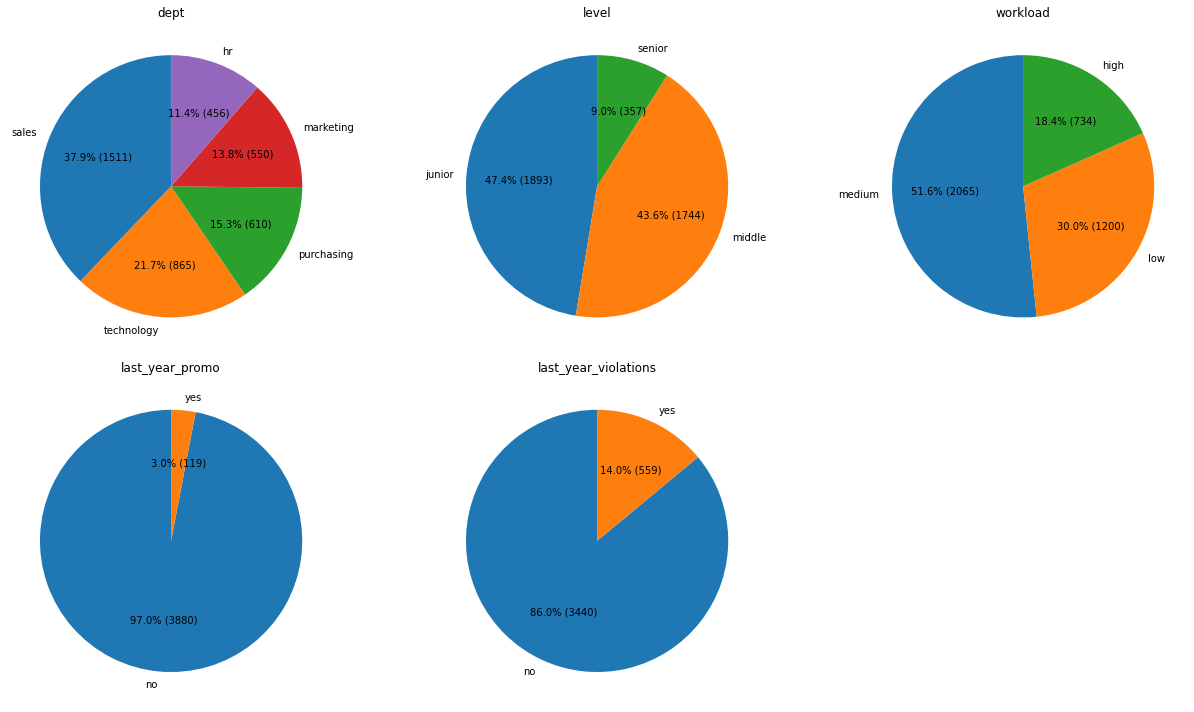

In [28]:
plot_categorical_columns(train_js)

- `dept`: Большая часть сотрудников работает в отделе продаж, sales - 37.9%.
- `level`: Большинство сотрудников находятся на младших и средних должностях, junior - 47.4%, middle - 43.6%.
- `workload`: У большинства сотрудников средняя рабочая нагрузка, medium - 51.6%.
- `last_year_promo`: Очень небольшой процент сотрудников был повышен в прошлом году, yes - 3%.
- `last_year_violations`: Большая часть сотрудников не имела нарушений в прошлом году, no - 86%.

**Изучим признак `employment_years`**.


=== Описательная статистика для 'employment_years' ===
count    4000.000000
mean        3.718500
std         2.542513
min         1.000000
25%         2.000000
50%         3.000000
75%         6.000000
max        10.000000
Name: employment_years, dtype: float64

Количество выбросов в 'employment_years': 0


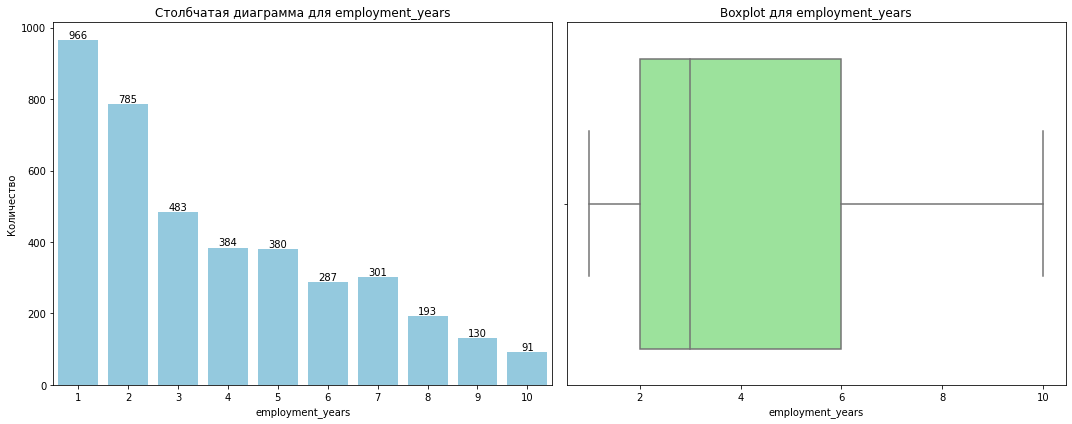

In [29]:
discrete_columns(train_js, 'employment_years')

По столбчатой диагремме признака `employment_years`, можно сказать, что большинство сотрудников имеют небольшой стаж работы (до 2 лет), что может указывать либо на то, что компания относительно молодая, либо на высокую текучесть кадров.

Большинство сотрудников со средним стажем: Основная масса сотрудников имеет стаж от 2 до 6 лет. Медианное значение признака - 3 года. Это, возможно, наиболее стабильная часть персонала

**Изучим признак `supervisor_evaluation`**.


=== Описательная статистика для 'supervisor_evaluation' ===
count    4000.000000
mean        3.476500
std         1.008812
min         1.000000
25%         3.000000
50%         4.000000
75%         4.000000
max         5.000000
Name: supervisor_evaluation, dtype: float64

Количество выбросов в 'supervisor_evaluation': 201


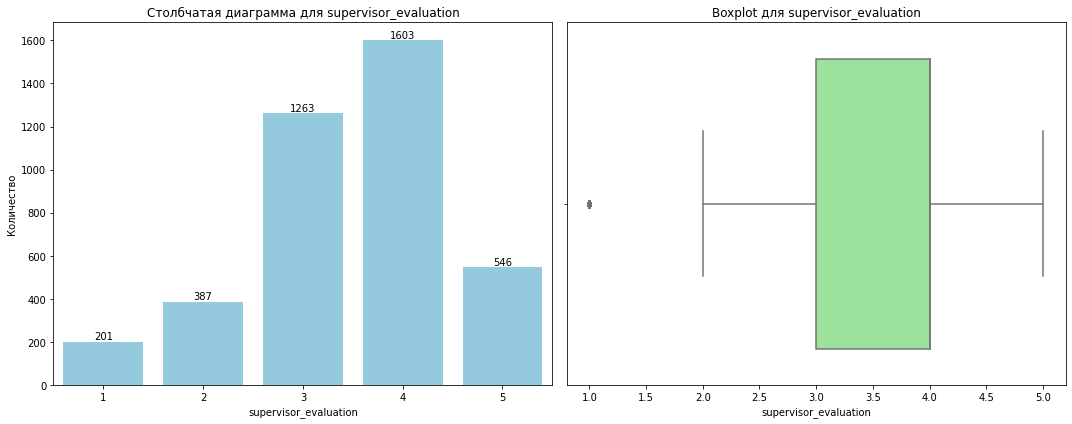

In [30]:
discrete_columns(train_js, 'supervisor_evaluation')

Изучение распределения признака `supervisor_evaluation` выявило, что большинство сотрудников получают оценки выше среднего (3 и 4). Количество выбросов, расположенных ниже оценки "3", относительно невелико, но присутствуют. Наличие выбросов можно связать с ассиметрией при распределение оценок, так как большенство работников получают средние оцеки.

**Изучим признак `salary`**.


=== Описательная статистика для 'salary' ===
count     4000.000000
mean     33926.700000
std      14900.703838
min      12000.000000
25%      22800.000000
50%      30000.000000
75%      43200.000000
max      98400.000000
Name: salary, dtype: float64

Количество выбросов в 'salary': 60


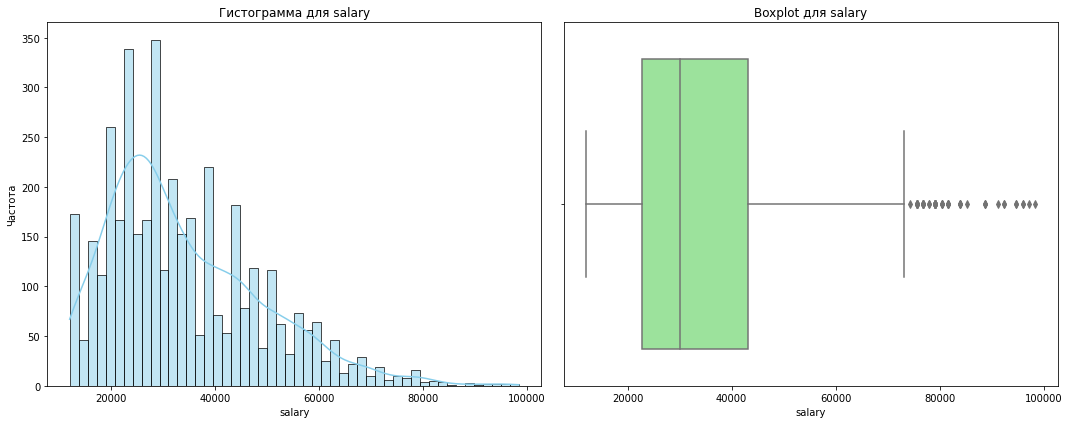

In [31]:
number_columns(train_js, 'salary')

Признак зарплаты является интвоым (дискретным), но было решено рассмотреть его как непрерывный, с использованием гистограммы.

Распределение признака `salary`, близкое к нормальному, большая часть значений сосредоточена в левой части графика, а более высокие значения (зарплаты) встречаются реже. Медианное значение признака зарплаты равно - 30000.

In [32]:
display_outliers(train_js, 'salary')

Выбросы в столбце 'salary':


id        dept   level workload  employment_years last_year_promo  \
45    538347  technology  senior     high                 3              no   
141   128304   marketing  senior     high                 7              no   
196   486576   marketing  senior     high                 9              no   
360   405345   marketing  senior     high                 7              no   
427   399126       sales  senior     high                 2              no   
494   590999  purchasing  senior     high                10              no   
1040  301946          hr  senior     high                 7              no   
1203  493024  technology  senior     high                10              no   
1241  148024  technology  senior     high                 4              no   
1491  796799   marketing  senior     high                 4              no   
1543  775511       sales  senior     high                 5              no   
1591  598754  purchasing  senior     high                 4              no   
1655  611498       sales  senior     high                 8              no   
1718  712878  purchasing  senior     high                 9              no   
1799  494125   marketing  senior     high                10              no   
1855  355174  technology  senior     high                 6              no   
1899  642094  technology  senior     high                 6              no   
1979  701051       sales  senior     high                 2              no   
1981  961485  technology  senior     high                 9              no   
1982  978915  technology  senior     high                 7              no   
2146  229741       sales  senior     high                 2              no   
2199  111346  purchasing  senior     high                 1              no   
2248  881760   marketing  senior     high                 6              no   
2429  722664  technology  senior     high                 8              no   
2430  501243          hr  senior     high                 8              no   
2435  649514       sales  senior     high                 7              no   
2469  771794  technology  senior     high                 5              no   
2670  985583  technology  senior     high                 3             yes   
2691  777049          hr  senior     high                 8              no   
2702  673796       sales  senior     high                 5              no   
2712  348150   marketing  senior     high                10              no   
2717  681745  technology  senior     high                 5              no   
2746  717479  technology  senior     high                 6              no   
2750  493986  technology  senior     high                 9             yes   
2774  441370  technology  senior     high                 5              no   
2810  829015       sales  senior     high                 4              no   
2845  839346  technology  senior     high                 5              no   
2901  930908  technology  senior     high                10              no   
2932  335600   marketing  senior     high                 4              no   
3016  147589  technology  senior     high                 2              no   
3024  494924  technology  senior     high                 6              no   
3080  385165   marketing  senior     high                 8             yes   
3150  811299   marketing  senior     high                 8              no   
3178  585770  purchasing  senior     high                 2              no   
3239  243490  purchasing  senior     high                 4              no   
3249  875175       sales  senior     high                 8              no   
3302  835479  purchasing  senior     high                 2              no   
3303  485850          hr  senior     high                 7              no   
3458  437486       sales  senior     high                 9              no   
3461  546721   marketing  senior     high                 5 

Выбросы в признаке `salary` решено оставить, так как они ими не являются. Наличие их в датасете можно объяснить высоким уровнем занимаемой должности работника.

**Изучим целевой признак `job_satisfaction_rate`**.


=== Описательная статистика для 'job_satisfaction_rate' ===
count    4000.000000
mean        0.533995
std         0.225327
min         0.030000
25%         0.360000
50%         0.560000
75%         0.710000
max         1.000000
Name: job_satisfaction_rate, dtype: float64

Количество выбросов в 'job_satisfaction_rate': 0


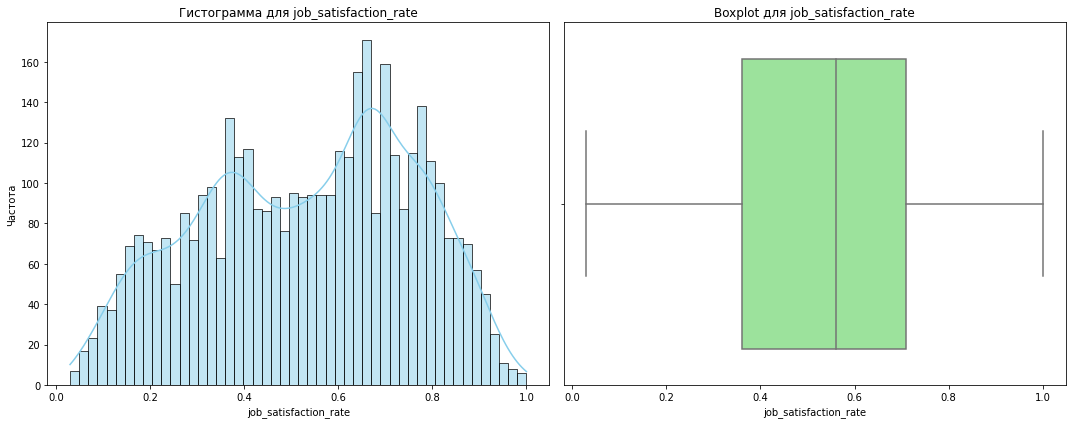

In [33]:
number_columns(train_js, 'job_satisfaction_rate')

На графике изображено распределение, которое выглядит как смесь двух нормальных распределений. В контексте `job_satisfaction_rate`, это может означать, что выборке есть две группы сотрудников: одна с более низким уровнем удовлетворенности, а другая с более высоким. Выбросов не обнаружено.

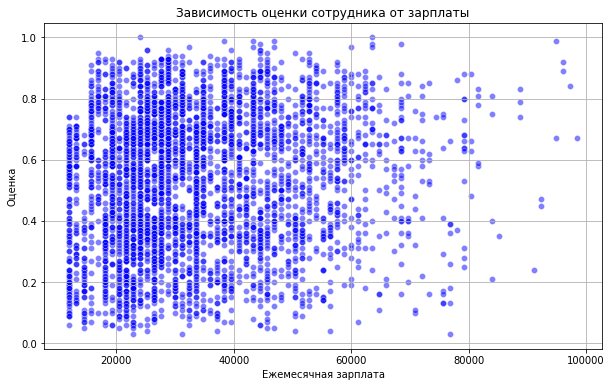

In [34]:
# График зависимости job_satisfaction_rate от salary
plt.figure(figsize=(10, 6))
sns.scatterplot(data=train_js, x='salary', y='job_satisfaction_rate', alpha=0.5, color='blue')
plt.title('Зависимость оценки сотрудника от зарплаты')
plt.xlabel('Ежемесячная зарплата')
plt.ylabel('Оценка')
plt.grid(True)
plt.show()

График не демонстрирует четкой зависимости между ежемесячной зарплатой и оценкой сотрудника. Это означает, что более высокая зарплата не гарантирует более высокую оценку, и наоборот.

Выполним более глубокий анализ на этапе построения матрицы корреляции.

**Изучим тестовый датасет `X_test_js`:**

Выполним сравнение тренировочной и тестовой выборок, это поможет:
- Убедиться, что тестовые данные содержат те же категории (`dept, level, workload`).
- Проверить, что распределения признаков имеет схожую структуру и распределение (не сильно отличаются от тренировочной).
- Определить, что целевой признак идентичный в двух датасетах.

Создадим функцию которая поможет в этом.

In [35]:
def compare_train_test(train_data, test_data, variable, title, xlabel, norm=False):

    plt.figure(figsize=(10, 6))
    
    # Построение графиков
    train_counts = train_data[variable].value_counts(normalize=norm).sort_index()
    test_counts = test_data[variable].value_counts(normalize=norm).sort_index()
    
    # Наложение графиков
    train_counts.plot.bar(color='skyblue', alpha=0.7, label='Тренировочная выборка')
    test_counts.plot.bar(color='lightgreen', alpha=0.7, label='Тестовая выборка')
    
    # Настройка графика
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel('Количество')
    plt.legend(title='Выборка')
    plt.grid(True)
    plt.tight_layout()
    plt.show()

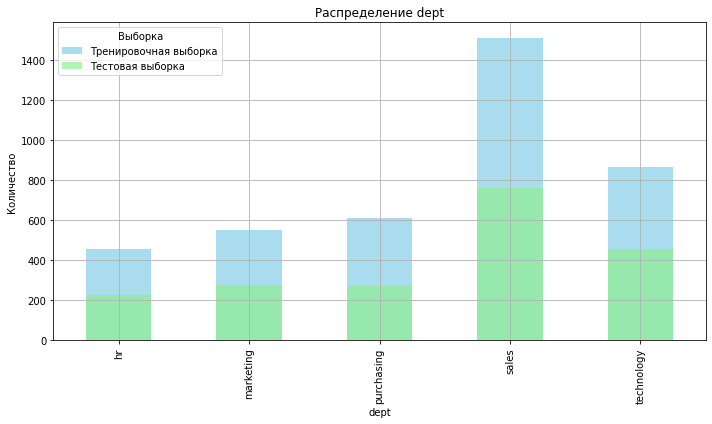

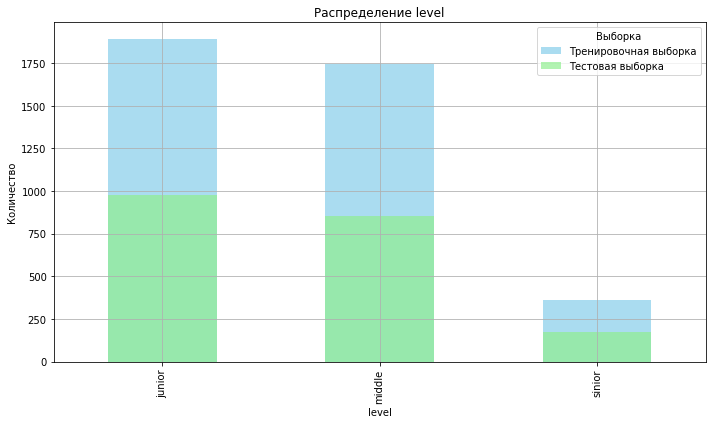

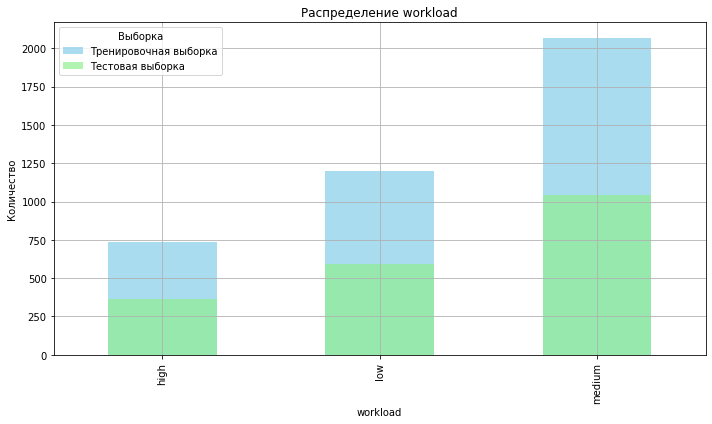

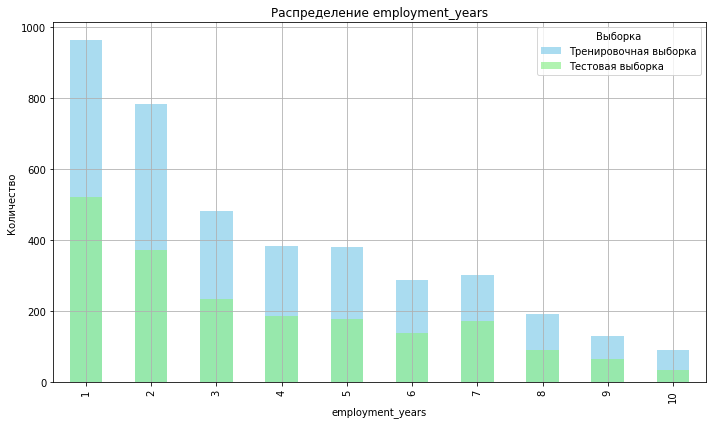

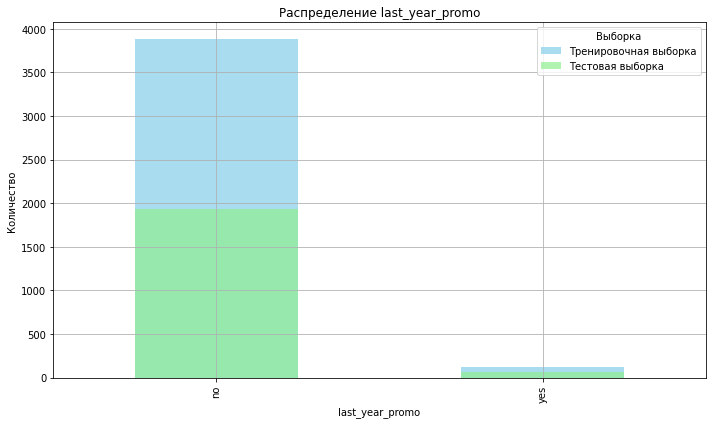

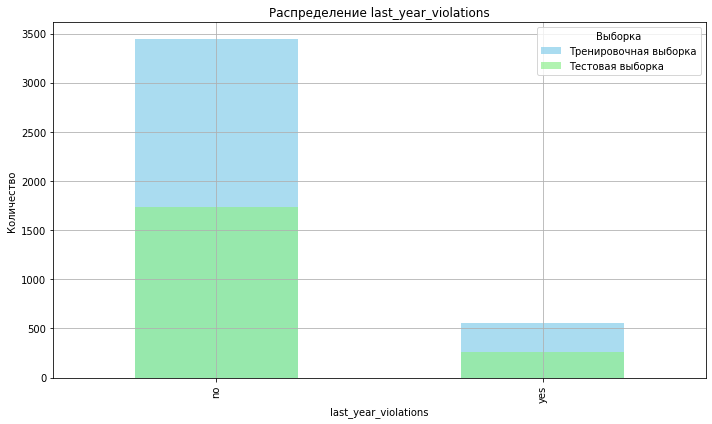

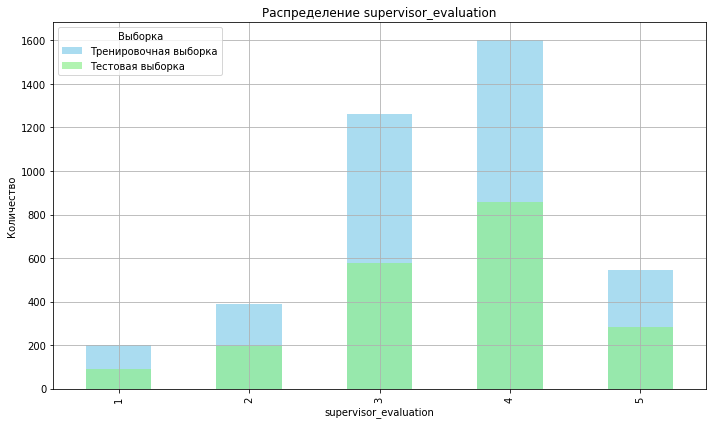

In [36]:
# Сравнение для первой задачи
for var in ['dept', 'level', 'workload', 'employment_years', 'last_year_promo',
                                            'last_year_violations', 'supervisor_evaluation']:
    compare_train_test(train_js, X_test_js, var, f'Распределение {var}', var)

По результатом сравнения признаков тренировочной и тестовой выборок можно сказать, что сильных отличай нет. Выполненный исследовательский анализ, для тренировочной выборки применим и к тестовой выборке.

Для завершения анализа, также выполним сравнение тренировочной и тестовой выборки по признакам `solary` и `job_satisfaction_rate` (целевой признак).

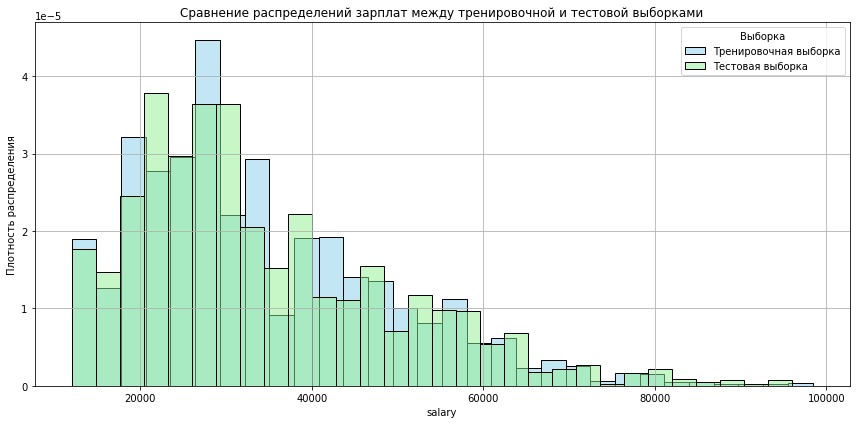

In [37]:
plt.figure(figsize=(12, 6))

# Наложение графиков с нормализацией (stat='density')
sns.histplot(data=train_js, x='salary', 
             color='skyblue', alpha=0.5, bins=30, label='Тренировочная выборка', stat='density')
sns.histplot(data=X_test_js, x='salary', 
             color='lightgreen', alpha=0.5, bins=30, label='Тестовая выборка', stat='density')

# Добавим заголовки для осей
plt.title('Сравнение распределений зарплат между тренировочной и тестовой выборками')
plt.xlabel('salary')  # Используем название столбца
plt.ylabel('Плотность распределения')
plt.grid(True)

# Добавим легенду
plt.legend(title='Выборка')

# Вывод графика
plt.tight_layout()
plt.show()

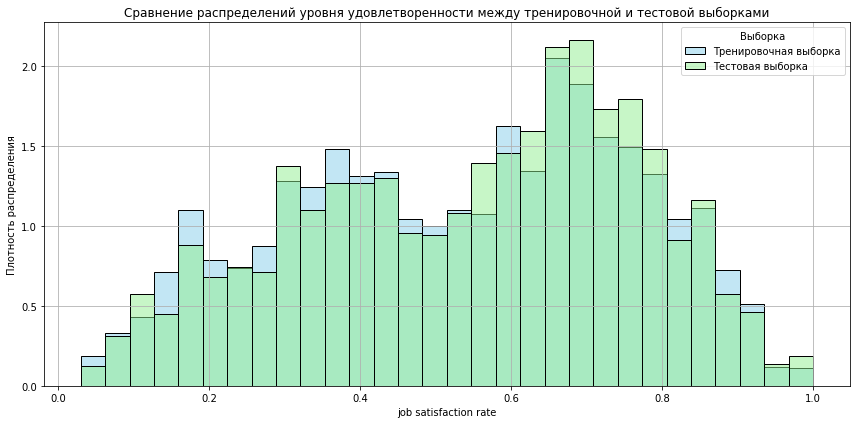

In [38]:
plt.figure(figsize=(12, 6))

# Наложение графиков с нормализацией (stat='density')
sns.histplot(data=train_js, x='job_satisfaction_rate', 
             color='skyblue', alpha=0.5, bins=30, label='Тренировочная выборка', stat='density')
sns.histplot(data=y_test_js, x='job_satisfaction_rate', 
             color='lightgreen', alpha=0.5, bins=30, label='Тестовая выборка', stat='density')

# Добавим заголовки для осей
plt.title('Сравнение распределений уровня удовлетворенности между тренировочной и тестовой выборками')
plt.xlabel('job satisfaction rate')  # Используем название столбца
plt.ylabel('Плотность распределения')
plt.grid(True)

# Добавим легенду
plt.legend(title='Выборка')

# Вывод графика
plt.tight_layout()
plt.show()

В распределении тренировочной и тестовой выборке сильных отличай нет.

**Выполним анализ датасета `y_test_js`:**

In [39]:
y_test_js.describe()

id  job_satisfaction_rate
count    2000.000000             2000.00000
mean   552765.213500                0.54878
std    253851.326129                0.22011
min    100298.000000                0.03000
25%    339052.000000                0.38000
50%    550793.000000                0.58000
75%    765763.750000                0.72000
max    999029.000000                1.00000


=== Описательная статистика для 'job_satisfaction_rate' ===
count    2000.00000
mean        0.54878
std         0.22011
min         0.03000
25%         0.38000
50%         0.58000
75%         0.72000
max         1.00000
Name: job_satisfaction_rate, dtype: float64

Количество выбросов в 'job_satisfaction_rate': 0


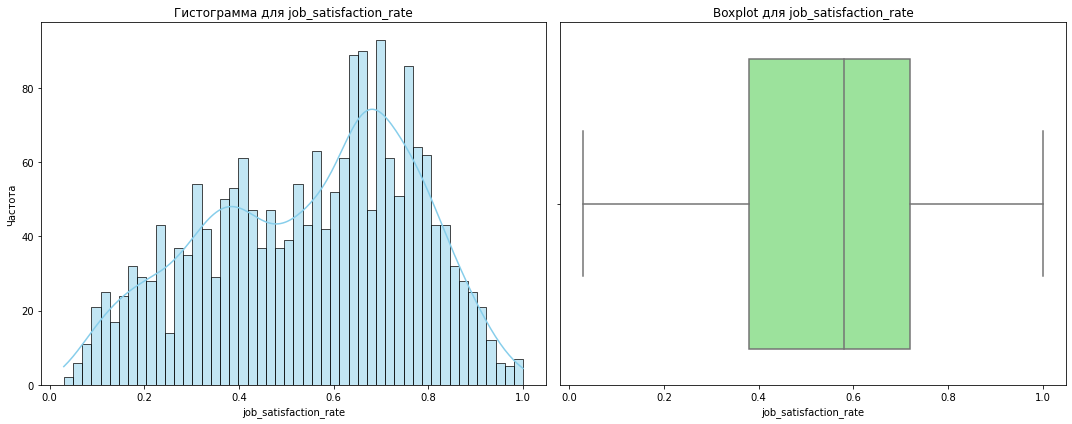

In [40]:
number_columns(y_test_js, 'job_satisfaction_rate')

Признак, `job_satisfaction_rate` в тестовой выборке, имеет почти такое же распределение, как и в тренировочной.

### Задача 2 - Исследовательский анализ данных

Построим гарфики для анализа категориальных признаков датасета `train_q`, для второй задачи.

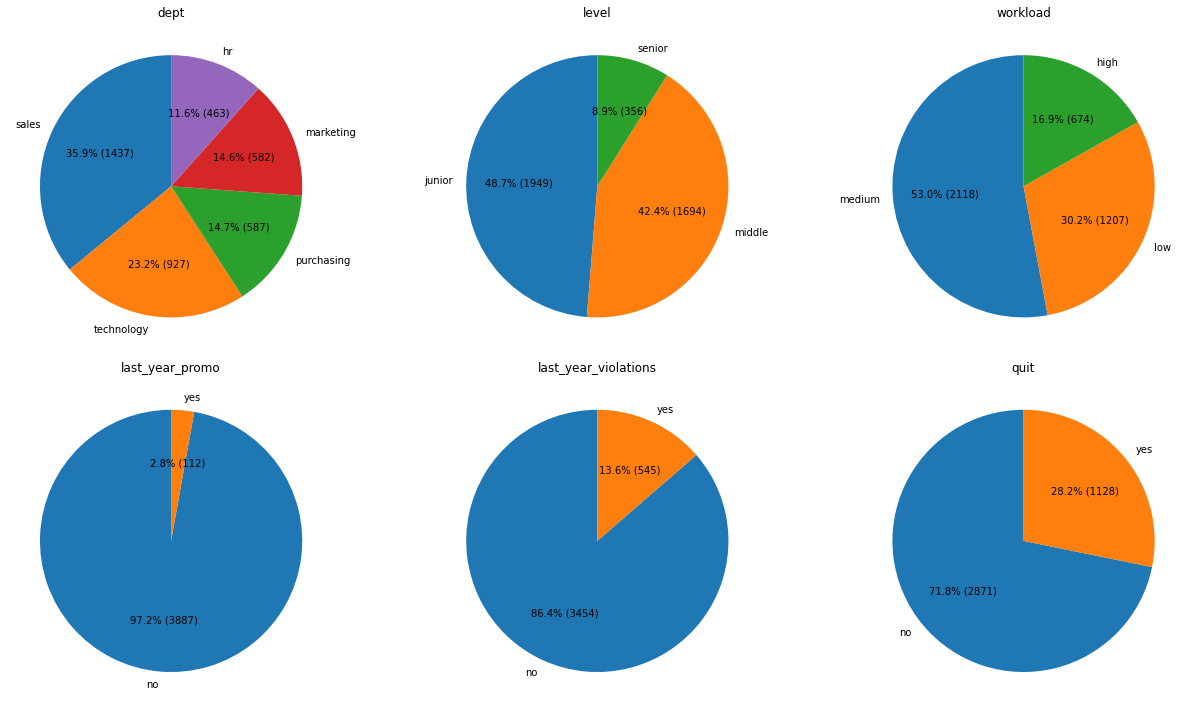

In [41]:
plot_categorical_columns(train_q)

- Самый большой отдел в признаке `dept` - отдел продаж (`sales - 35.9%`).
- Большинство сотрудников в признаке `level` - младшие специалисты (`junior - 48.7%`).
- Большинство сотрудников в признаке `workload` имеют среднюю рабочую нагрузку (`medium - 53%`).
- Большинство сотрудников в признаке `last_year_promo` не совершали нарушений (`no - 97.2%`).
- Большинство сотрудников в признаке `last_year_violations` не получали повышения в прошлом году (`no - 86.4%`).
- Довольно большой процент сотрудников в целевом признаке `quit` рассматривает увольнение (`yes - 28.2%`).

**Изучим признак `employment_years`**, для второй задачи.


=== Описательная статистика для 'employment_years' ===
count    4000.000000
mean        3.701500
std         2.541852
min         1.000000
25%         2.000000
50%         3.000000
75%         6.000000
max        10.000000
Name: employment_years, dtype: float64

Количество выбросов в 'employment_years': 0


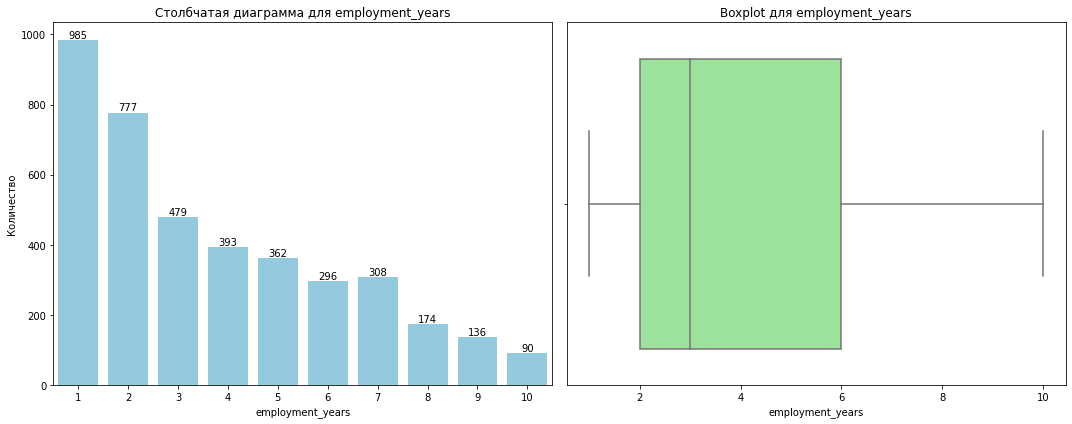

In [42]:
discrete_columns(train_q, 'employment_years')

По столбчатой диагремме признака `employment_years`, для второй задачи, можно сказать, что большинство сотрудников имеют небольшой стаж работы (до 2 лет), что может указывать либо на то, что компания относительно молодая, либо на высокую текучесть кадров.

Большинство сотрудников со средним стажем: Основная масса сотрудников имеет стаж от 2 до 6 лет. Медианное значение признака - 3 года. Это, возможно, наиболее стабильная часть персонала

**Изучим признак `supervisor_evaluation`**, для второй задачи.


=== Описательная статистика для 'supervisor_evaluation' ===
count    4000.000000
mean        3.474750
std         1.004049
min         1.000000
25%         3.000000
50%         4.000000
75%         4.000000
max         5.000000
Name: supervisor_evaluation, dtype: float64

Количество выбросов в 'supervisor_evaluation': 202


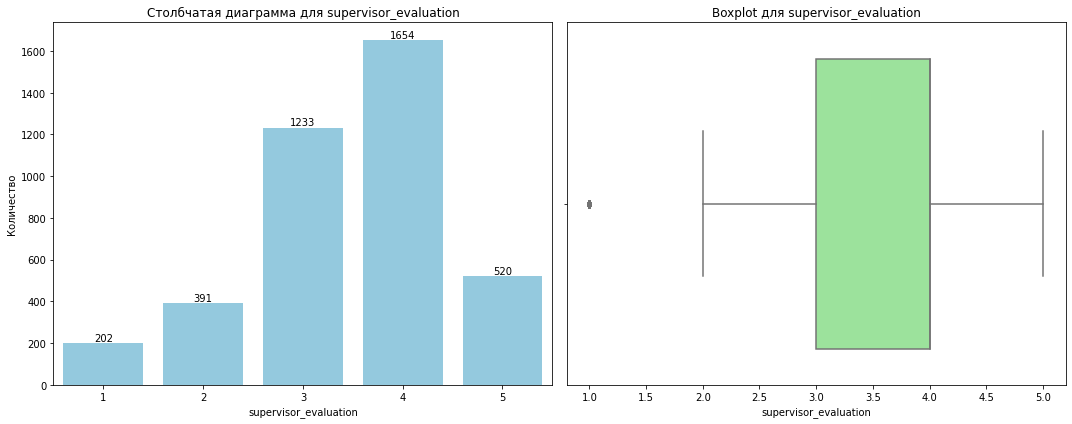

In [43]:
discrete_columns(train_q, 'supervisor_evaluation')

Изучение распределения признака `supervisor_evaluation`, для второй задачи, выявило, что большинство сотрудников получают оценки выше среднего (3 и 4). Количество выбросов, расположенных ниже оценки "3", относительно невелико, но присутствуют. Наличие выбросов можно связать с ассиметрией при распределение оценок, так как большенство работников получают средние оцеки.

**Изучим признак `salary`**, для второй задачи.


=== Описательная статистика для 'salary' ===
count     4000.000000
mean     33805.800000
std      15152.415163
min      12000.000000
25%      22800.000000
50%      30000.000000
75%      43200.000000
max      96000.000000
Name: salary, dtype: float64

Количество выбросов в 'salary': 78


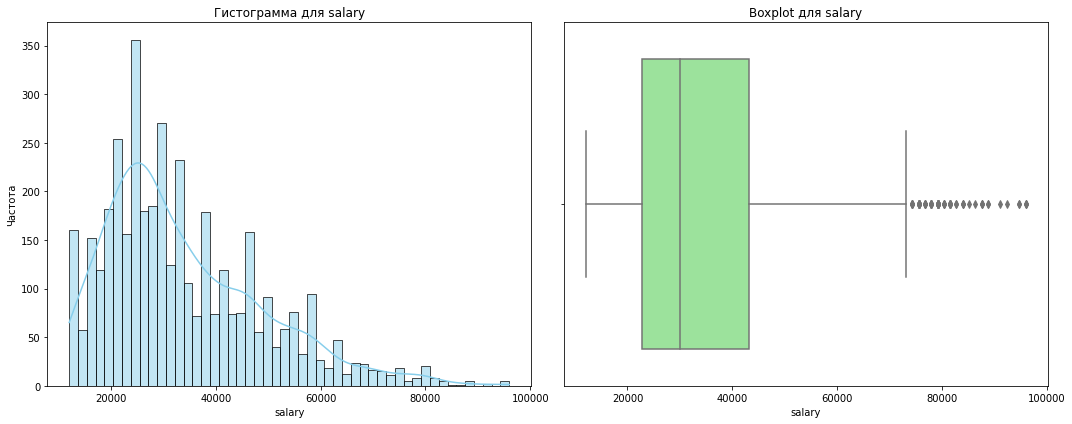

In [44]:
number_columns(train_q, 'salary')

Распределение признака `salary`, для второй задачи, близкое к нормальному, большая часть значений сосредоточена в левой части графика, а более высокие значения (зарплаты) встречаются реже. Медианное значение признака зарплаты равно - 30000.

Выбросы в признаке `salary`, во втрой задаче так же решено оставить, так как они ими не являются. Наличие их в датасете можно объяснить высоким уровнем занимаемой должности работника.

**Портрет «уволившегося сотрудника»**

Построим график зависимости целевого признака увольнения `quit` от зарплаты `salary`, для второй задачи.

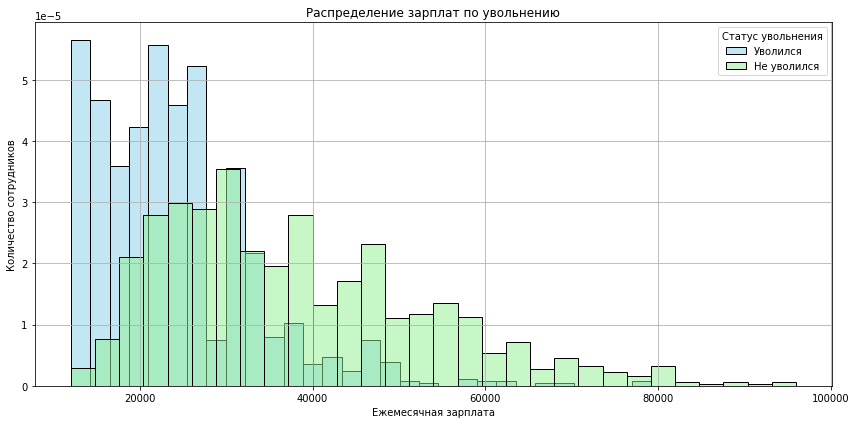

In [45]:
# Гистограмма
plt.figure(figsize=(12, 6))
sns.histplot(data=train_q[train_q['quit'] == 'yes'], x='salary', 
             color='skyblue', alpha=0.5, bins=30, stat='density')
sns.histplot(data=train_q[train_q['quit'] == 'no'], x='salary', 
             color='lightgreen', alpha=0.5, bins=30, stat='density')

# Добавим заголовки для осей
plt.title('Распределение зарплат по увольнению')
plt.xlabel('Ежемесячная зарплата')
plt.ylabel('Количество сотрудников')
plt.grid(True)

# Добавим легенду
plt.legend(['Уволился', 'Не уволился'], title='Статус увольнения')

# Вывод графика
plt.tight_layout()
plt.show()

Для удобства дальнейшего изучения выделим подвыборки уволившихся сотрудников.

In [46]:
# Подвыборка для уволившихся сотрудников
quit_yes = train_q[train_q['quit'] == 'yes']
quit_no = train_q[train_q['quit'] == 'no']

print(f"Количество уволившихся: {len(quit_yes)}")
print(f"Количество оставшихся: {len(quit_no)}")

Количество уволившихся: 1128
Количество оставшихся: 2872


In [47]:
display(quit_yes.head())
quit_no.head()

id        dept   level workload  employment_years last_year_promo  \
3   257132       sales  junior   medium                 2              no   
5   699916       sales  junior      low                 1              no   
9   613206  technology  middle   medium                 2              no   
24  468145  technology  junior   medium                 2              no   
25  982346   marketing  junior   medium                 3              no   

   last_year_violations  supervisor_evaluation  salary quit  
3                   yes                      3   24000  yes  
5                   yes                      3   18000  yes  
9                    no                      3   45600  yes  
24                   no                      3   30000  yes  
25                   no                      3   30000  yes

id        dept   level workload  employment_years last_year_promo  \
0  723290       sales  middle     high                 2              no   
1  814010       sales  junior   medium                 2              no   
2  155091  purchasing  middle   medium                 5              no   
4  910140   marketing  junior   medium                 2              no   
6  417070  technology  middle   medium                 8              no   

  last_year_violations  supervisor_evaluation  salary quit  
0                   no                      4   54000   no  
1                   no                      4   27600   no  
2                   no                      1   37200   no  
4                   no                      5   25200   no  
6                   no                      2   44400   no

In [48]:
# Сравнение средних
print(f"Средняя зарплата уволившихся: {quit_yes['salary'].mean():.2f}")
print(f"Средняя зарплата оставшихся: {quit_no['salary'].mean():.2f}")

Средняя зарплата уволившихся: 23885.11
Средняя зарплата оставшихся: 37702.23


По построенному графику и выполненному расчету можно определить, что низкая зарплата, приводит к повышению вероятности увольнения: Сотрудники с низкими зарплатами (до 24 000) более склонны к увольнению.

Зарплата - не единственный фактор: Распределение показывает, что есть сотрудники с зарплатой до 60 000, которые все равно увольняются, и сотрудники с низкой зарплатой, которые остаются в компании. Следовательно, на решение об увольнении могут влиять и другие факторы.

Узнаем, в каком отделе с большей вероятностью работает уволившийся сотрудник.

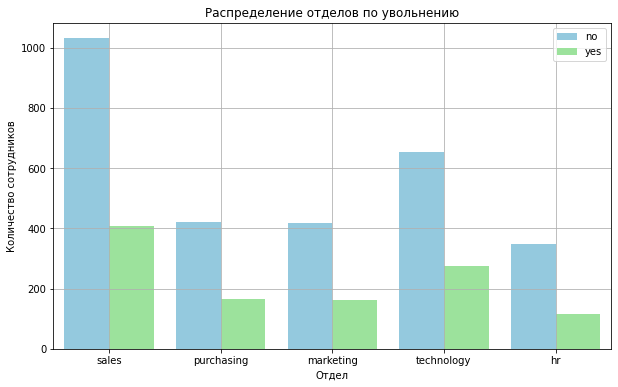

In [49]:
# Распределение отделов среди уволившихся и оставшихся
plt.figure(figsize=(10, 6))

# Создаем пользовательскую палитру
custom_palette = sns.color_palette(['skyblue', 'lightgreen'])

# Строим график
sns.countplot(data=train_q, x='dept', hue='quit', palette=custom_palette)
plt.title('Распределение отделов по увольнению')
plt.xlabel('Отдел')
plt.ylabel('Количество сотрудников')
plt.grid(True)
plt.legend()
plt.show()

In [50]:
# Сравнение долей
resigned_dept = quit_yes['dept'].value_counts(normalize=True).to_frame(name='Уволившиеся')
not_resigned_dept = quit_no['dept'].value_counts(normalize=True).to_frame(name='Оставшиеся')
# Объединение результатов
display(pd.concat([resigned_dept, not_resigned_dept], axis=1).fillna(0))

Уволившиеся  Оставшиеся
sales          0.360816    0.358983
technology     0.244681    0.227019
purchasing     0.147163    0.146936
marketing      0.144504    0.145891
hr             0.102837    0.121170

- Уволившиеся чаще всего работают в отделах sales и technology.
- Сотрудники из отдела hr реже покидают компанию.

Узнаем какой уровень должности у уволившегося сотрудника.

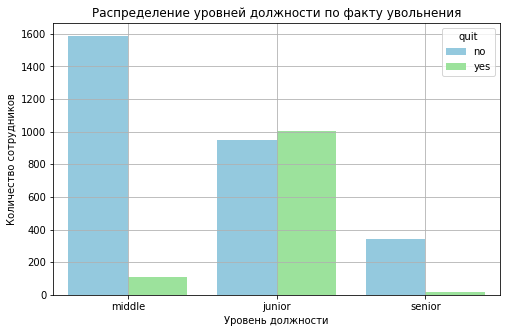

In [51]:
# Распределение уровней должности среди уволившихся и оставшихся
plt.figure(figsize=(8, 5))
sns.countplot(data=train_q, x='level', hue='quit', palette=custom_palette)
plt.title('Распределение уровней должности по факту увольнения')
plt.xlabel('Уровень должности')
plt.ylabel('Количество сотрудников')
plt.grid(True)
plt.show()

In [52]:
# Сравнение долей
resigned_level = quit_yes['level'].value_counts(normalize=True).to_frame(name='Уволившиеся')
not_resigned_level = quit_no['level'].value_counts(normalize=True).to_frame(name='Оставшиеся')
display(pd.concat([resigned_level, not_resigned_level], axis=1).fillna(0))

Уволившиеся  Оставшиеся
junior     0.889184    0.329387
middle     0.095745    0.552228
senior     0.015071    0.118384

- Большинство уволившихся — младшие специалисты (junior).
- Старшие специалисты (senior) реже покидают компанию.

Узнаем какой уровень загруженности у уволившегося сотрудника.

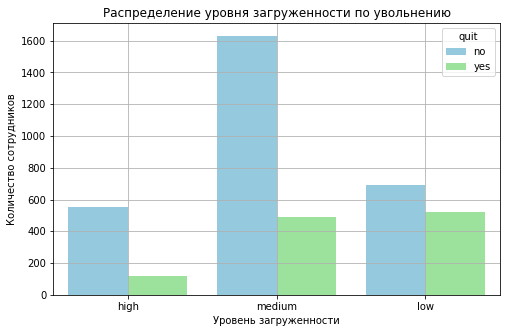

In [53]:
# Распределение уровня загруженности среди уволившихся и оставшихся
plt.figure(figsize=(8, 5))
sns.countplot(data=train_q, x='workload', hue='quit', palette=custom_palette)
plt.title('Распределение уровня загруженности по увольнению')
plt.xlabel('Уровень загруженности')
plt.ylabel('Количество сотрудников')
plt.grid(True)
plt.show()

In [54]:
# Сравнение долей
resigned_workload = quit_yes['workload'].value_counts(normalize=True).to_frame(name='Уволившиеся')
not_resigned_workload = quit_no['workload'].value_counts(normalize=True).to_frame(name='Оставшиеся')
display(pd.concat([resigned_workload, not_resigned_workload], axis=1).fillna(0))

Уволившиеся  Оставшиеся
low        0.460106    0.239903
medium     0.432624    0.567549
high       0.107270    0.192549

- Уволившиеся сотрудники чаще имеют низкую или среднюю нагрузку.
- У высокой загруженности меньшая вероятность увольнения.

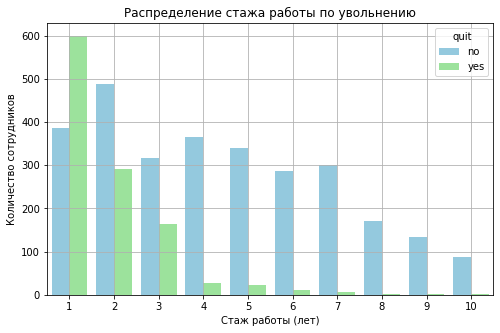

In [55]:
# Распределение стажа работы среди уволившихся и оставшихся
plt.figure(figsize=(8, 5))
sns.countplot(data=train_q, x='employment_years', hue='quit', palette=custom_palette)
plt.title('Распределение стажа работы по увольнению')
plt.xlabel('Стаж работы (лет)')
plt.ylabel('Количество сотрудников')
plt.grid(True)
plt.show()

In [56]:
# Сравнение средних значений
print(f"Средний стаж уволившихся: {quit_yes['employment_years'].mean():.2f} лет")
print(f"Средний стаж оставшихся: {quit_no['employment_years'].mean():.2f} лет")

Средний стаж уволившихся: 1.84 лет
Средний стаж оставшихся: 4.43 лет


In [57]:
# Объединение групп по стажу работы
resigned_employment_years = pd.cut(quit_yes['employment_years'], 
                                   bins=[0, 2, 3, float('inf')], 
                                   labels=['<2 года', '2–3 года', '>3 года']).value_counts(
                                                                                    normalize=True).to_frame(name='Уволившиеся')

not_resigned_employment_years = pd.cut(quit_no['employment_years'], 
                                       bins=[0, 2, 3, float('inf')], 
                                       labels=['<2 года', '2–3 года', '>3 года']).value_counts(
                                                                                    normalize=True).to_frame(name='Оставшиеся')

display(pd.concat([resigned_employment_years, not_resigned_employment_years], axis=1).fillna(0))

Уволившиеся  Оставшиеся
<2 года      0.788121    0.303969
2–3 года     0.144504    0.110028
>3 года      0.067376    0.586003

- Уволившиеся сотрудники чаще всего работают менее 2 лет.
- После 3 лет вероятность увольнения резко снижается.

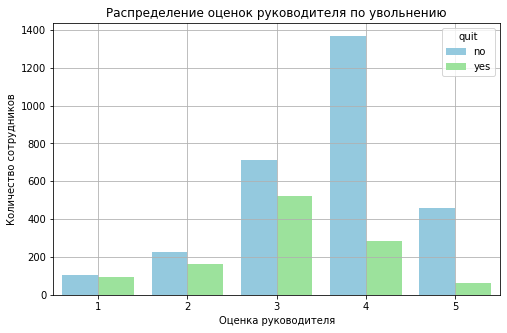

In [58]:
# Распределение оценок руководителя среди уволившихся и оставшихся
plt.figure(figsize=(8, 5))
sns.countplot(data=train_q, x='supervisor_evaluation', hue='quit', palette=custom_palette)
plt.title('Распределение оценок руководителя по увольнению')
plt.xlabel('Оценка руководителя')
plt.ylabel('Количество сотрудников')
plt.grid(True)
plt.show()

In [59]:
# Сравнение долей
resigned_sup_eval = quit_yes['supervisor_evaluation'].value_counts(normalize=True).to_frame(name='Уволившиеся')
not_resigned_sup_eval = quit_no['supervisor_evaluation'].value_counts(normalize=True).to_frame(name='Оставшиеся')
display(pd.concat([resigned_sup_eval, not_resigned_sup_eval], axis=1).fillna(0))

Уволившиеся  Оставшиеся
1     0.084220    0.037256
2     0.145390    0.079039
3     0.463652    0.247214
4     0.253546    0.476323
5     0.053191    0.160167

- Уволившиеся сотрудники чаще получают оценку 3.
- Оставшиеся сотрудники чаще получают оценку 4.

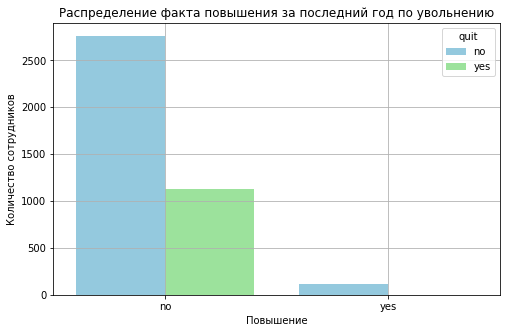

In [60]:
# Распределение повышения за год среди уволившихся и оставшихся
plt.figure(figsize=(8, 5))
sns.countplot(data=train_q, x='last_year_promo', hue='quit', palette=custom_palette)
plt.title('Распределение факта повышения за последний год по увольнению')
plt.xlabel('Повышение')
plt.ylabel('Количество сотрудников')
plt.grid(True)
plt.show()

In [61]:
# Сравнение долей
resigned_promo = quit_yes['last_year_promo'].value_counts(normalize=True).to_frame(name='Уволившиеся')
not_resigned_promo = quit_no['last_year_promo'].value_counts(normalize=True).to_frame(name='Оставшиеся')
display(pd.concat([resigned_promo, not_resigned_promo], axis=1).fillna(0))

Уволившиеся  Оставшиеся
no      0.999113    0.961003
yes     0.000887    0.038997

- Уволившиеся сотрудники крайне редко получали повышения `yes`, меньше 1%.
- Оставшиеся сотрудники также редко получали повышения, но доля немного выше `yes` - 3.89%.

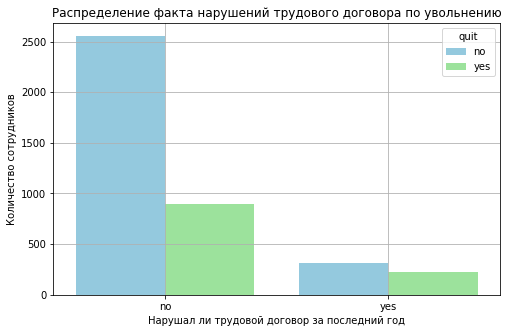

In [62]:
# Распределение факта нарушений среди уволившихся и оставшихся
plt.figure(figsize=(8, 5))
sns.countplot(data=train_q, x='last_year_violations', hue='quit', palette=custom_palette)
plt.title('Распределение факта нарушений трудового договора по увольнению')
plt.xlabel('Нарушал ли трудовой договор за последний год')
plt.ylabel('Количество сотрудников')
plt.grid(True)
plt.show()

In [63]:
# Сравнение долей нарушивших трудовой договор
resigned_violations = quit_yes['last_year_violations'].value_counts(normalize=True).to_frame(name='Уволившиеся')
not_resigned_violations = quit_no['last_year_violations'].value_counts(normalize=True).to_frame(name='Оставшиеся')
display(pd.concat([resigned_violations, not_resigned_violations], axis=1).fillna(0))

Уволившиеся  Оставшиеся
no      0.797872    0.889624
yes     0.202128    0.110376

- Уволившиеся сотрудники реже совершали нарушения трудового договора `no` - 96.8%.
- Оставшиеся сотрудники также реже не совершали нарушений `no` - 98.4%.

Выполним проверку утверждения о влиянии уровня удовлетворённости `job_satisfaction_rate` на вероятность увольнения `quit`.

In [64]:
test_full = y_test_js.merge(y_test_q, on='id', how='left')
test_full.head()

id  job_satisfaction_rate quit
0  130604                   0.74   no
1  825977                   0.75   no
2  418490                   0.60  yes
3  555320                   0.72   no
4  826430                   0.08  yes

In [65]:
quit_yes = test_full[test_full['quit'] == 'yes']
quit_no = test_full[test_full['quit'] == 'no']

print(f"Количество уволившихся: {len(quit_yes)}")
print(f"Количество оставшихся: {len(quit_no)}")

Количество уволившихся: 564
Количество оставшихся: 1436


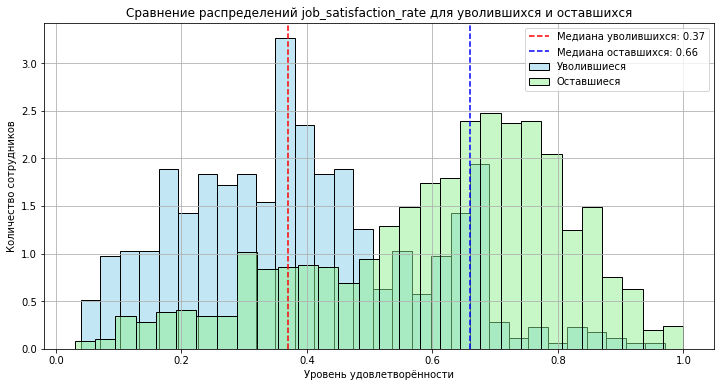

In [66]:
# Гистограмма
plt.figure(figsize=(12, 6))
sns.histplot(quit_yes['job_satisfaction_rate'], bins=30, 
             label='Уволившиеся', color='skyblue', alpha=0.5, stat='density')
sns.histplot(quit_no['job_satisfaction_rate'], bins=30, 
             label='Оставшиеся', color='lightgreen', alpha=0.5, stat='density')

# Добавляем медианы
median_quit_yes = quit_yes['job_satisfaction_rate'].median()
median_quit_no = quit_no['job_satisfaction_rate'].median()
plt.axvline(median_quit_yes, color='red', linestyle='--', label=f'Медиана уволившихся: {median_quit_yes:.2f}')
plt.axvline(median_quit_no, color='blue', linestyle='--', label=f'Медиана оставшихся: {median_quit_no:.2f}')

# Настройка графика
plt.title('Сравнение распределений job_satisfaction_rate для уволившихся и оставшихся')
plt.xlabel('Уровень удовлетворённости')
plt.ylabel('Количество сотрудников')
plt.legend()
plt.grid(True)
plt.show()

In [67]:
mean_ratio = quit_yes['job_satisfaction_rate'].mean() / quit_no['job_satisfaction_rate'].mean()
print(f"Отношение средних значений: {mean_ratio:.2f}")

Отношение средних значений: 0.63


Среднее значение удовлетворенности работой, равна 63% это означает, что среднее значение удовлетворенности среди уволившихся сотрудников на 37% ниже, чем среди тех, кто не уволился.

In [68]:
median_ratio = median_quit_yes / median_quit_no
print(f"Отношение медианных значений: {median_ratio:.2f}")

Отношение медианных значений: 0.56


Медианное значение удовлетворенности работой, равна 56% это означает, что медианное значение удовлетворенности среди уволившихся сотрудников на 44% ниже, чем среди тех, кто не уволился.

**Портрет уволившегося сотрудника будет следующим:**

Среднем сотрудник работал меньше 2 лет, имеет низкую или среднюю загруженность, имел низкую должность - джун, скорее всего работал в отделе продаж, средняя зарплата была примерна равна 24 000 рублей. За время работы не получил повышение. Сотрудники, которые уволились, были менее удовлетворены своей работой, средняя удовлетворенности уволившегося равна 63%.

**Изучим тестовый датасет `X_test_q`, для второй задачи:**

Данные `X_test_q` аналогичен по содержанию содержанию и распределению, как в первой задаче.

Выполним сравнение тренировочной (`train_q`) и тестовой выборок (`X_test_q`) для второй задачи, это поможет:
- Проверить, что распределения признаков имеет схожую структуру и распределение (не сильно отличаются от тренировочной).

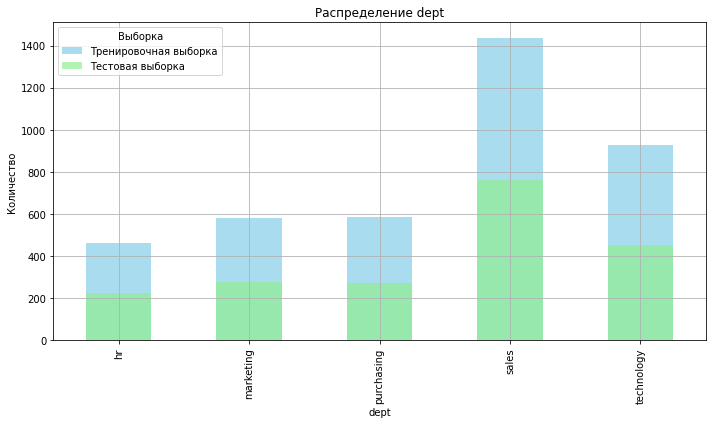

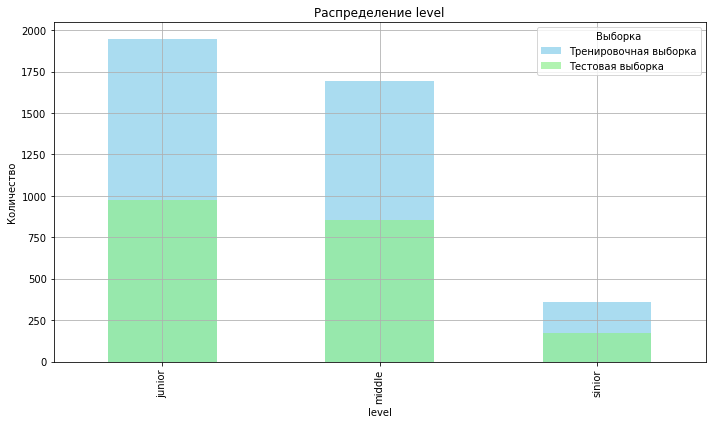

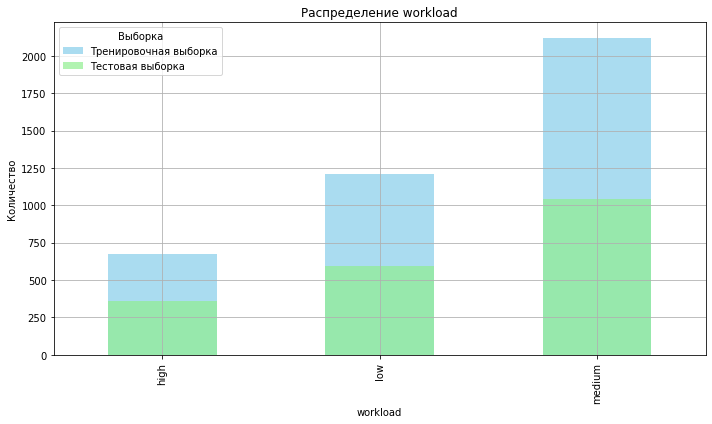

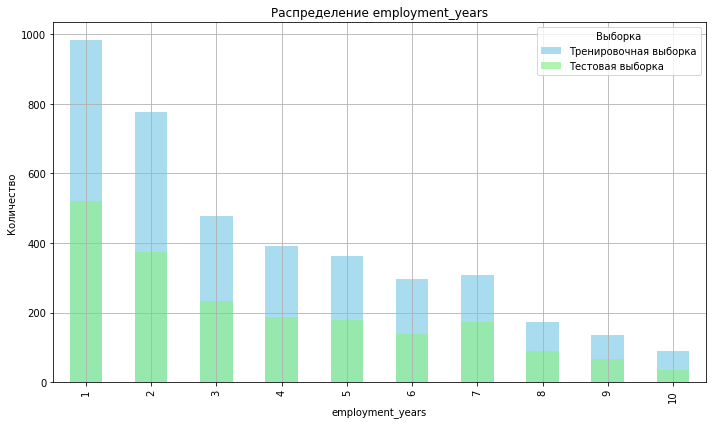

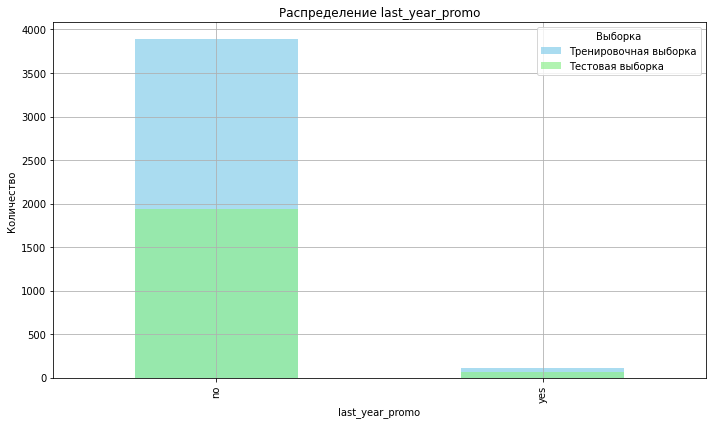

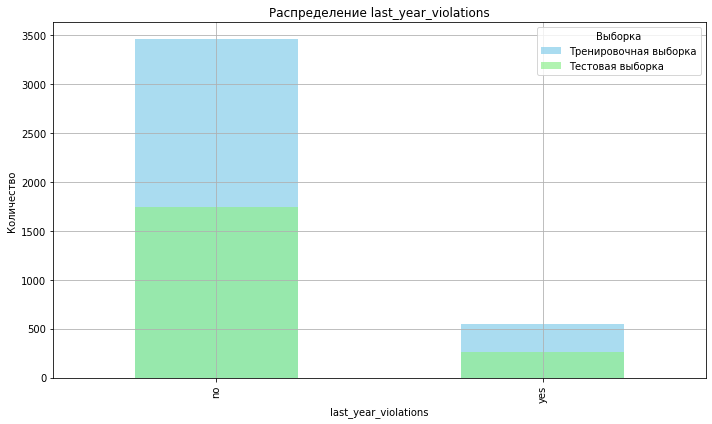

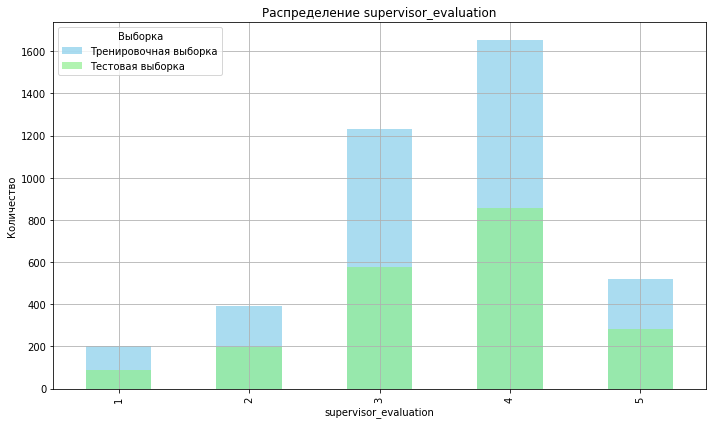

In [69]:
# Сравнение для первой задачи
for var in ['dept', 'level', 'workload', 'employment_years', 'last_year_promo',
                                            'last_year_violations', 'supervisor_evaluation']:
    compare_train_test(train_q, X_test_q, var, f'Распределение {var}', var)

По результатом сравнения признаков тренировочной и тестовой выборок, для второй задачи, можно сказать, что сильных отличай нет. Выполненный исследовательский анализ, для тренировочной выборки применим и к тестовой выборке.

Для завершения анализа, также выполним сравнение тренировочной и тестовой выборки по признакам `solary` и `quit` (целевой признак) для второй задачи.

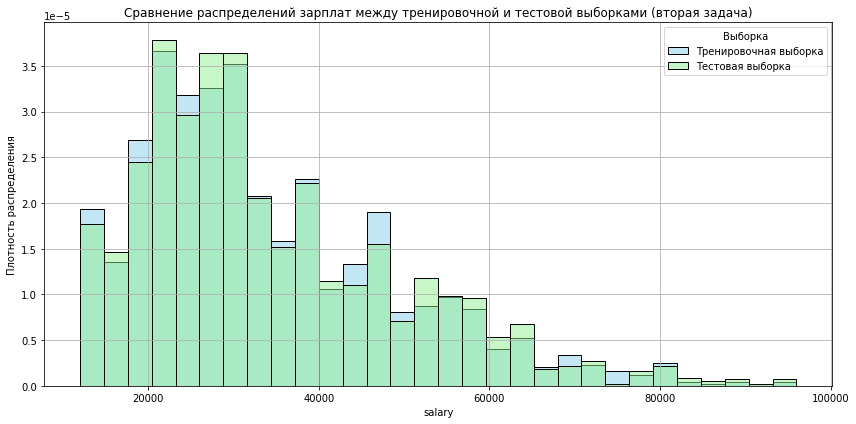

In [70]:
plt.figure(figsize=(12, 6))

# Наложение графиков с нормализацией (stat='density')
sns.histplot(data=train_q, x='salary', 
             color='skyblue', alpha=0.5, bins=30, label='Тренировочная выборка', stat='density')
sns.histplot(data=X_test_q, x='salary', 
             color='lightgreen', alpha=0.5, bins=30, label='Тестовая выборка', stat='density')

# Добавим заголовки для осей
plt.title('Сравнение распределений зарплат между тренировочной и тестовой выборками (вторая задача)')
plt.xlabel('salary')  # Используем название столбца
plt.ylabel('Плотность распределения')
plt.grid(True)

# Добавим легенду
plt.legend(title='Выборка')

# Вывод графика
plt.tight_layout()
plt.show()

В распределении тренировочной `train_q` и тестовой выборке `X_test_q`, для втрой задачи сильных отличай нет.

**Выполним анализ датасета `y_test_q`, для второй задачи:**

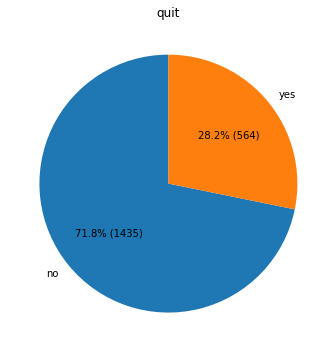

In [71]:
plot_categorical_columns(y_test_q)

Довольно большой процент сотрудников в целевом признаке `quit` рассматривает увольнение (`yes - 28.2%`). Целевой признак аналогичен по распределению как целевой признак `quit` в тренировочной выборке.

> **Промежуточный итог: Исследовательский анализ данных**
> 
> **Для первой задачи (предсказание уровня удовлетворенности):**
>
> 1. **Общий обзор данных:**
> - Тренировочный датасет (`train_js`) содержит 4000 записей и 10 признаков.
> - Тестовый датасет с признаками (`X_test_js`) содержит 2000 записей и 9 признаков.
> - Целевой признак тестового датасета (`y_test_js`) содержит 2000 записей.
>
>
> 2. **Категориальные признаки:**
> - **`dept`:** Большинство сотрудников работают в отделе продаж (`sales - 37.9%`). Другие отделы представлены меньше, но распределение между тренировочной и тестовой выборками совпадает.
> - **`level`:** Преобладают младшие специалисты (`junior - 47.4%`), затем средние (`middle - 43.6%`). Высоких должностей (`senior`) очень мало.
> - **`workload`:** Средняя загруженность (`medium - 51.6%`) является наиболее распространенной. `low` и высокая `high` загруженность встречаются реже.
> - **`last_year_promo`:** Лишь небольшая часть сотрудников была повышена за последний год (`yes - 3%`).
> - **`last_year_violations`:** Подавляющее большинство сотрудников не нарушило трудовой договор (`no - 86%`).
>
>
> 3. **Числовые признаки:**
> - **`employment_years`:** Распределение показывает, что большинство сотрудников работает менее 2 лет. Это может указывать на высокую текучесть кадров.
> - **`supervisor_evaluation`:** Оценки руководителя сосредоточены вокруг средних значений (3–4). Низкие оценки (`1–2`) встречаются реже, но они есть.
> - **`salary`:** Распределение зарплат близко к нормальному, с пиками в диапазоне 20–40 тысяч рублей. Высокие зарплаты (>60 тысяч) встречаются реже, но их нельзя считать выбросами, так как они связаны с уровнем должности.
> - **`job_satisfaction_rate`:** Целевой признак имеет два пика: около 0.3 и 0.7. Это может говорить о двух группах сотрудников — недовольных и удовлетворенных своей работой.
>
>
> 4. **Сравнение тренировочной и тестовой выборок:**
> - Категориальные признаки (`dept`, `level`, `workload`, `last_year_promo`, `last_year_violations`) имеют схожее распределение.
> - Числовые признаки (`employment_years`, `supervisor_evaluation`, `salary`) также демонстрируют схожие распределения.
> - Целевой признак (`job_satisfaction_rate`) в тестовой выборке (`y_test_js`) имеет аналогичное распределение, что и в тренировочной.
---
> **Для второй задачи (предсказание увольнения):**
>
> 1. **Общий обзор данных:**
> - Тренировочный датасет (`train_q`) содержит 4000 записей и 10 признаков.
> - Тестовый датасет с признаками (`X_test_q`) содержит 2000 записей и 9 признаков.
> - Целевой признак тестового датасета (`y_test_q`) содержит 2000 записей.
>
>
> 2. **Категориальные признаки:**
> - **`dept`:** Наиболее крупные отделы — `sales` (35.9%) и `technology`. Другие отделы представлены меньше, но структура совпадает с первой задачей.
> - **`level`:** Преобладают младшие специалисты (`junior - 48.7%`), затем средние (`middle - 42.4%`). Высокие должности (`senior`) занимают минимальную долю.
> - **`workload`:** Средняя загруженность (`medium - 53%`) является самой распространенной. `low` и `high` встречаются реже.
> - **`last_year_promo`:** Лишь малый процент сотрудников был повышен за последний год (`yes - 3%`).
> - **`last_year_violations`:** Большинство сотрудников не совершило нарушений (`no - 86.4%`).
> - **`quit`:** Примерно (`yes - 28.2%`) сотрудников покинули компанию. Это говорит о существенном дисбалансе классов.
>
>
> 3. **Числовые признаки:**
> - **`employment_years`:** Как и в первой задаче, большинство сотрудников работает менее 2 лет. Это может быть связано с молодостью компании или высокой текучестью кадров.
> - **`supervisor_evaluation`:** Оценки руководителя сосредоточены вокруг средних значений (3–4). Низкие оценки (`1–2`) встречаются реже.
> - **`salary`:** Распределение зарплат аналогично первой задаче, с пиками в диапазоне 20–40 тысяч рублей.
>
>
> 4. **Портрет «уволившегося сотрудника»:**
> - **Зарплата:** Средняя зарплата уволившихся сотрудников равна ~24 000 рублей, средней зарплаты оставшихся ~38 000 рублей.
> - **Отдел:** Уволившиеся сотрудники чаще всего работают в отделах `sales` (около 36.1%) и `technology` (около 24.5%). Сотрудники из отдела `hr` реже покидают компанию.
> - **Уровень должности:** Преобладают младшие специалисты `junior` (88.9%), наблюдается высокая текучесть среди новичков.
> - **Рабочая нагрузка:** Уволившиеся сотрудники чаще имеют низкую `low` (ококло 46.0%) или среднюю `medium` (43.0%) рабочую нагрузку. Высокая нагрузка (`high - 10.0%`) ассоциируется с меньшей вероятностью увольнения.
> - **Стаж работы:** Средний стаж уволившихся сотрудников составляет ~1.8 года. Большинство уволившихся работает менее 2 лет.
>
>
> 5. **Сравнение тренировочной и тестовой выборок:**
> - Распределения категориальных признаков (`dept`, `level`, `workload`, `last_year_promo`, `last_year_violations`) практически одинаковы.
> - Числовые признаки (`employment_years`, `supervisor_evaluation`, `salary`) также демонстрируют схожие распределения.
> - Целевой признак (`quit`) в тестовой выборке (`y_test_q`) имеет аналогичное распределение, что и в тренировочной.

## Корреляционный анализ

Проведем корреляционный анализ для выявления взаимосвязей между признаками. Это поможет нам понять, какие переменные наиболее сильно влияют на целевые показатели (`job_satisfaction_rate` для первой задачи и `quit` для второй). Для этого будем использовать матрицу корреляций (`phik_matrix`) для оценки линейных и нелинейных зависимостей.

### Задача 1 - Корреляционный анализ

Для построения матрицы корреляции в первой задаче будем использовать датасет `train_js`. 

In [72]:
train_js.describe()

id  employment_years  supervisor_evaluation        salary  \
count    4000.000000       4000.000000            4000.000000   4000.000000   
mean   544957.621000          3.718500               3.476500  33926.700000   
std    257883.104622          2.542513               1.008812  14900.703838   
min    100954.000000          1.000000               1.000000  12000.000000   
25%    322836.750000          2.000000               3.000000  22800.000000   
50%    534082.500000          3.000000               4.000000  30000.000000   
75%    771446.000000          6.000000               4.000000  43200.000000   
max    999521.000000         10.000000               5.000000  98400.000000   

       job_satisfaction_rate  
count            4000.000000  
mean                0.533995  
std                 0.225327  
min                 0.030000  
25%                 0.360000  
50%                 0.560000  
75%                 0.710000  
max                 1.000000

In [73]:
train_js.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4000 entries, 0 to 3999
Data columns (total 10 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   id                     4000 non-null   int64  
 1   dept                   3994 non-null   object 
 2   level                  3996 non-null   object 
 3   workload               4000 non-null   object 
 4   employment_years       4000 non-null   int64  
 5   last_year_promo        4000 non-null   object 
 6   last_year_violations   4000 non-null   object 
 7   supervisor_evaluation  4000 non-null   int64  
 8   salary                 4000 non-null   int64  
 9   job_satisfaction_rate  4000 non-null   float64
dtypes: float64(1), int64(4), object(5)
memory usage: 312.6+ KB


In [74]:
# Избавимся от столбца `id` и всех дискретных и категориальных столбцов
interval_cols_js = [col for col in train_js.columns 
                  if col not in ['id', 'dept',
                                 'level', 'workload',
                                 'employment_years', 'last_year_promo',
                                 'last_year_violations', 'supervisor_evaluation']]
interval_cols_js

['salary', 'job_satisfaction_rate']

In [75]:
# Создадим копию датасета, чтобы удалить 'id'
train_js_corr = train_js.copy().drop('id', axis=1)
train_js_corr.head()

dept   level workload  employment_years last_year_promo  \
0       sales  junior   medium                 2              no   
1          hr  junior     high                 2              no   
2       sales  junior      low                 1              no   
3  technology  junior      low                 4              no   
4          hr  junior   medium                 1              no   

  last_year_violations  supervisor_evaluation  salary  job_satisfaction_rate  
0                   no                      1   24000                   0.58  
1                   no                      5   38400                   0.76  
2                   no                      2   12000                   0.11  
3                   no                      2   18000                   0.37  
4                   no                      3   22800                   0.20

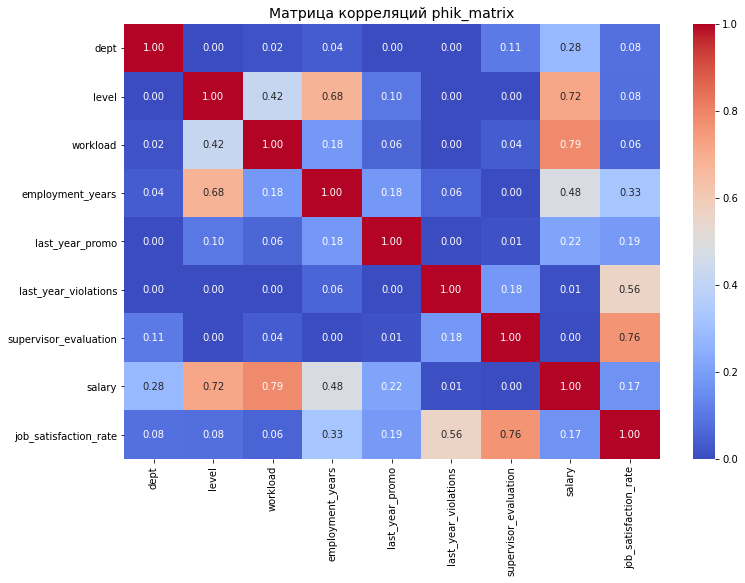

In [76]:
# Визуализируем матрицу корреляции
plt.figure(figsize=(12, 8))
sns.heatmap(train_js_corr.phik_matrix(interval_cols=interval_cols_js), annot=True, fmt='.2f', cmap="coolwarm")
plt.title('Матрица корреляций phik_matrix', fontsize=14)
plt.show()

In [77]:
# Определим признаки, которые наиболее сильно коррелируют с уровенем удовлетворенности сотрудника работой.
train_js_corr.phik_matrix(interval_cols=interval_cols_js)['job_satisfaction_rate'].sort_values(ascending=False).round(2)

job_satisfaction_rate    1.00
supervisor_evaluation    0.76
last_year_violations     0.56
employment_years         0.33
last_year_promo          0.19
salary                   0.17
dept                     0.08
level                    0.08
workload                 0.06
Name: job_satisfaction_rate, dtype: float64

Выполним проверку корреляции для тестовой выборки `X_test_js` второго задания.

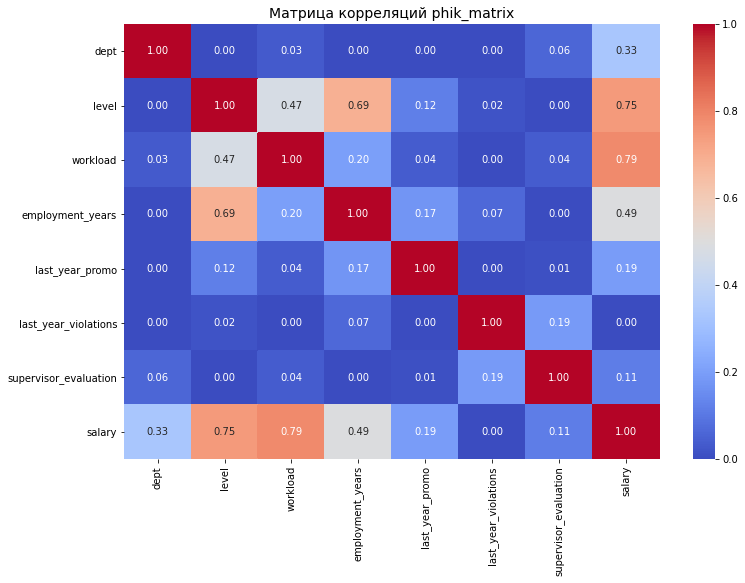

In [78]:
# Визуализируем матрицу корреляции
plt.figure(figsize=(12, 8))
sns.heatmap(X_test_js.drop('id', axis=1).phik_matrix(interval_cols=interval_cols_js), annot=True, fmt='.2f', cmap="coolwarm")
plt.title('Матрица корреляций phik_matrix', fontsize=14)
plt.show()

Из-за схожести распределений в тренировочном и тестовом выборках, сильных корреляционных различий не наблюдается.

**Анализ матрицы корреляции для первой задачи (предсказание уровня удовлетворенности):**

1.  **Сильные положительные корреляции:**
- `level` и `salary` (0.72): Более высокий уровень должности связан с более высокой зарплатой.
- `level` и `employment_years` (0.68): Более высокий уровень должности связан с большим стажем работы.
- `salary` и `workload` (0.79): Более высокая зарплата связана с более высокой рабочей нагрузкой.
- `job_satisfaction_rate` и `supervisor_evaluation` (0.76): Высокая оценка руководителя связана с высокой удовлетворенностью работой.

2.  **Умеренные корреляции:**
- `job_satisfaction_rate` и `last_year_violations` (0.56): Отсутствие факта нарушения в прошлом году может быть связано с более высокой удовлетворенностью работой.
- `job_satisfaction_rate` и `employment_years` (0.33): Больший стаж работы может быть связан с более высокой удовлетворенностью работой.

3.  **Слабые или отсутствующие корреляции:**
- `job_satisfaction_rate` и `last_year_promo` (0.19): Получение повышения в прошлом году может быть связано с более высокой удовлетворенностью работой.
- `dept` практически не коррелирует ни с одной из других переменных (близко к 0).

**Общие выводы:**

- **Удовлетворенность работой:** Удовлетворенность работой тесно связана с оценкой руководителя и с фактом отсутствия нарушения в прошлом году.
- **Зарплата и должность:** Наблюдается ожидаемая связь между уровнем должности и зарплатой.
- **Незначительные факторы:** Отдел, в котором работает сотрудник, и наличие нарушений в прошлом году не оказывают значительного влияния на другие переменные.

### Задача 2 - Корреляционный анализ

Для построения матрицы корреляции во второй задаче будет использован датасет `train_q`. 

In [79]:
train_q.describe()

id  employment_years  supervisor_evaluation        salary
count    4000.000000       4000.000000            4000.000000   4000.000000
mean   552099.283750          3.701500               3.474750  33805.800000
std    260158.031387          2.541852               1.004049  15152.415163
min    100222.000000          1.000000               1.000000  12000.000000
25%    327785.750000          2.000000               3.000000  22800.000000
50%    546673.000000          3.000000               4.000000  30000.000000
75%    781497.750000          6.000000               4.000000  43200.000000
max    999915.000000         10.000000               5.000000  96000.000000

In [80]:
train_q.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4000 entries, 0 to 3999
Data columns (total 10 columns):
 #   Column                 Non-Null Count  Dtype 
---  ------                 --------------  ----- 
 0   id                     4000 non-null   int64 
 1   dept                   4000 non-null   object
 2   level                  4000 non-null   object
 3   workload               4000 non-null   object
 4   employment_years       4000 non-null   int64 
 5   last_year_promo        4000 non-null   object
 6   last_year_violations   4000 non-null   object
 7   supervisor_evaluation  4000 non-null   int64 
 8   salary                 4000 non-null   int64 
 9   quit                   4000 non-null   object
dtypes: int64(4), object(6)
memory usage: 312.6+ KB


In [81]:
# Избавимся от столбца `id` и всех дискретных и категориальных столбцов
interval_cols_q = [col for col in train_q.columns 
                  if col not in ['id', 'dept',
                                 'level', 'workload',
                                 'employment_years', 'last_year_promo',
                                 'last_year_violations', 'supervisor_evaluation', 'quit']]
interval_cols_q

['salary']

In [82]:
# Создадим копию датасета, чтобы удалить 'id'
train_q_corr = train_q.copy().drop('id', axis=1)
train_q_corr.head()

dept   level workload  employment_years last_year_promo  \
0       sales  middle     high                 2              no   
1       sales  junior   medium                 2              no   
2  purchasing  middle   medium                 5              no   
3       sales  junior   medium                 2              no   
4   marketing  junior   medium                 2              no   

  last_year_violations  supervisor_evaluation  salary quit  
0                   no                      4   54000   no  
1                   no                      4   27600   no  
2                   no                      1   37200   no  
3                  yes                      3   24000  yes  
4                   no                      5   25200   no

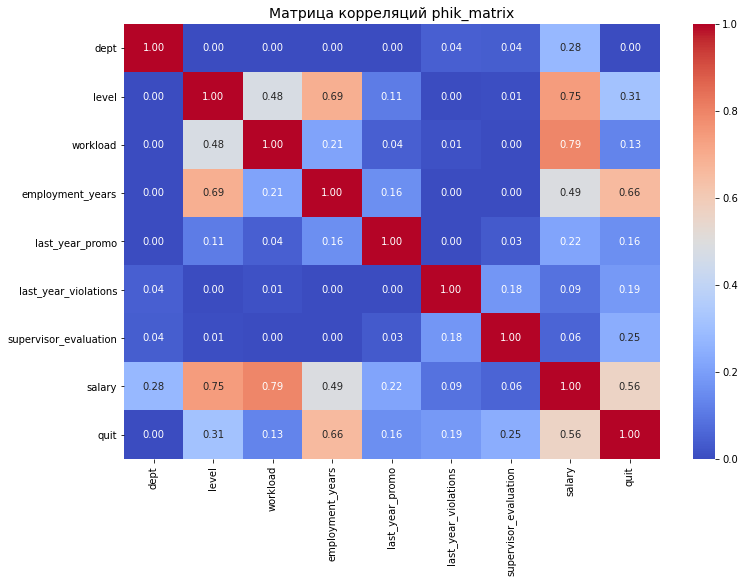

In [83]:
# Визуализируем матрицу корреляции
plt.figure(figsize=(12, 8))
sns.heatmap(train_q_corr.phik_matrix(interval_cols=interval_cols_q), annot=True, fmt='.2f', cmap="coolwarm")
plt.title('Матрица корреляций phik_matrix', fontsize=14)
plt.show()

In [84]:
# Определим признаки, которые наиболее сильно коррелируют с уровенем удовлетворенности сотрудника работой.
train_q_corr.phik_matrix(interval_cols=interval_cols_q)['quit'].sort_values(ascending=False).round(2)

quit                     1.00
employment_years         0.66
salary                   0.56
level                    0.31
supervisor_evaluation    0.25
last_year_violations     0.19
last_year_promo          0.16
workload                 0.13
dept                     0.00
Name: quit, dtype: float64

Выполним проверку корреляции для тестовой выборки `X_test_q` второго задания.

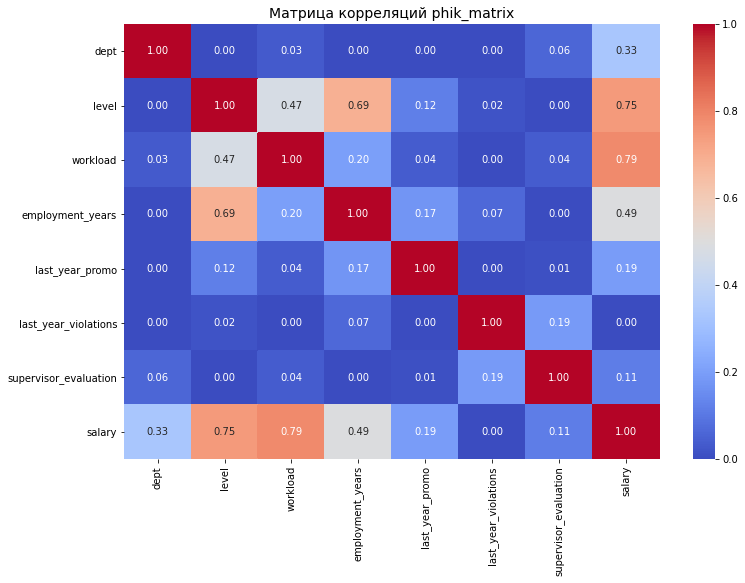

In [85]:
# Визуализируем матрицу корреляции
plt.figure(figsize=(12, 8))
sns.heatmap(X_test_q.drop('id', axis=1).phik_matrix(interval_cols=interval_cols_q), annot=True, fmt='.2f', cmap="coolwarm")
plt.title('Матрица корреляций phik_matrix', fontsize=14)
plt.show()

Из-за схожести распределений в тренировочном и тестовом выборках, сильных корреляционных различий не наблюдается.

**Анализ матрицы корреляции для второй задачи (предсказание увольнения):**

1.  **Сильные положительные корреляции:**
- `level` и `salary` (0.75): Более высокий уровень должности сильно связан с более высокой зарплатой.
- `level` и `employment_years` (0.69): Более высокий уровень должности связан с большим стажем работы.
- `workload` и `salary` (0.79): Более высокая рабочая нагрузка связана с более высокой зарплатой.

2.  **Умеренные положительные корреляции:**
- `quit` и `employment_years` (0.66): Наиболее сильная корреляция с целевым признаком - стаж работы. Чем больше стаж работы, тем меньше вероятность увольнения.
- `quit` и `salary` (0.56): Умеренная положительная корреляция с зарплатой. Чем выше зарплата, тем меньше вероятность увольнения.

3.  **Слабые или отсутствующие корреляции:**
- `quit` и `level` (0.31): Небольшая положительная корреляция с уровнем должности.
- `quit` и `supervisor_evaluation` (0.25): Слабая положительная корреляция с оценкой руководителя.
- `quit` и `last_year_violations` (0.19): Очень слабая корреляция с нарушениями в прошлом году.
- `quit` и `last_year_promo` (0.16): Очень слабая корреляция с получением повышения в прошлом году.
- `quit` и `workload` (0.13): Практически нет корреляции с рабочей нагрузкой.
- `dept` практически не коррелирует ни с одной из других переменных (значения близки к 0).

**Общие выводы:**

*   **Стаж работы - ключевой фактор:** Наиболее важным фактором, влияющим на увольнение, является стаж работы. Чем дольше сотрудник работает в компании, тем меньше вероятность его ухода.
*   **Зарплата важна:** Зарплата также играет важную роль, но её влияние не такое сильное, как у стажа работы.
*   **Оценка руководителя влияет слабо:** Оценка руководителя оказывает некоторое влияние, но оно невелико.
*   **Другие факторы менее значимы:** Отдел, рабочая нагрузка, нарушения в прошлом году и получение повышения в прошлом году оказывают незначительное влияние на увольнение.

> **Промежуточный итог: Корреляционному анализ**
>
> **Для первой задачи:**
>
> Удовлетворенность работой (`job_satisfaction_rate`) зависит:
> - В первую очередь от оценки руководителя (`supervisor_evaluation`).
> - Отсутствия нарушений (`last_year_violations`).
> - Стажа работы (`employment_years`).
> - В меньшей степени от зарплаты (`salary`) и должности (`level`).
> - Зависимость от категориальных признаков (`dept, workload`) слабая.
>
> **Для второй задачи:**
>
> Увольнение (`quit`) зависит:
> - В первую очередь от стажа работы (`employment_years`). Новые сотрудники (менее 2 лет) чаще уходят.
> - От зарплаты (`salary`). Низкие зарплаты увеличивают вероятность увольнения.
> - От уровня должности (`level`). Младшие специалисты (`junior`) чаще покидают компанию.
> - В меньшей степени от повышений (`last_year_promo`) и оценки руководителя (`supervisor_evaluation`).
> - Признаки `dept`, `workload`, `last_year_violations` имеют минимальное влияние на увольнение.

## Использование пайплайнов

### Подготовка данных для первой задачи

Установим столбец `id` как индекс, для удобства разаделения на выборки.

In [86]:
train_js_ml = train_js.set_index('id')
display(f'Количество дубликатов train_js_ml: {train_js_ml.duplicated().sum()}')

'Количество дубликатов train_js_ml: 245'

In [87]:
# Удалим дубликаты в `train_js_ml`
train_js_ml.drop_duplicates(inplace=True, ignore_index=False)
# Проверка
display(f'Количество дубликатов train_js_ml: {train_js_ml.duplicated().sum()}')
display(train_js_ml.head())

'Количество дубликатов train_js_ml: 0'

dept   level workload  employment_years last_year_promo  \
id                                                                      
155278       sales  junior   medium                 2              no   
653870          hr  junior     high                 2              no   
184592       sales  junior      low                 1              no   
171431  technology  junior      low                 4              no   
693419          hr  junior   medium                 1              no   

       last_year_violations  supervisor_evaluation  salary  \
id                                                           
155278                   no                      1   24000   
653870                   no                      5   38400   
184592                   no                      2   12000   
171431                   no                      2   18000   
693419                   no                      3   22800   

        job_satisfaction_rate  
id                             
155278                   0.58  
653870                   0.76  
184592                   0.11  
171431                   0.37  
693419                   0.20

In [88]:
# Выделим тренировочную и тестовую выборку после удаления дубликатов из `train_js_ml`
X_train_js_ml = train_js_ml.drop('job_satisfaction_rate', axis=1) # Выделяем тренировочную выборку
y_train_js_ml = train_js_ml['job_satisfaction_rate'] # Выделяем таргет в тренировочной выборке

# Устанавливаем индекс на 'id' в тестовой выборке
X_test_js_ml = X_test_js.set_index('id')
y_test_js_ml = y_test_js.set_index('id')
# Выполним объединение X_test_js_ml и y_test_js_ml, чтобы оставить только столбцы с одинаковым id
full_test_js = X_test_js_ml.merge(y_test_js_ml, right_index=True, left_index=True)
X_test_js_ml = full_test_js.drop('job_satisfaction_rate', axis=1) # Выделяем тествую выборку
y_test_js_ml = full_test_js['job_satisfaction_rate'] # Выделяем таргет в тествой выборке

In [89]:
# Проверяем размеры выборок
display(X_train_js_ml.head())
print(f"Размер X_train_js_ml: {X_train_js_ml.shape}")
display(y_train_js_ml.head())
print(f"Размер y_train_js_ml: {y_train_js_ml.shape}")

display(X_test_js_ml.head())
print(f"Размер X_test_js_ml: {X_test_js_ml.shape}")
display(y_test_js_ml.head())
print(f"Размер y_test_js_ml: {y_test_js_ml.shape}")

dept   level workload  employment_years last_year_promo  \
id                                                                      
155278       sales  junior   medium                 2              no   
653870          hr  junior     high                 2              no   
184592       sales  junior      low                 1              no   
171431  technology  junior      low                 4              no   
693419          hr  junior   medium                 1              no   

       last_year_violations  supervisor_evaluation  salary  
id                                                          
155278                   no                      1   24000  
653870                   no                      5   38400  
184592                   no                      2   12000  
171431                   no                      2   18000  
693419                   no                      3   22800

Размер X_train_js_ml: (3755, 8)


id
155278    0.58
653870    0.76
184592    0.11
171431    0.37
693419    0.20
Name: job_satisfaction_rate, dtype: float64

Размер y_train_js_ml: (3755,)


dept   level workload  employment_years last_year_promo  \
id                                                                     
485046  marketing  junior   medium                 2              no   
686555         hr  junior   medium                 1              no   
467458      sales  middle      low                 5              no   
418655      sales  middle      low                 6              no   
789145         hr  middle   medium                 5              no   

       last_year_violations  supervisor_evaluation  salary  
id                                                          
485046                   no                      5   28800  
686555                   no                      4   30000  
467458                   no                      4   19200  
418655                   no                      4   19200  
789145                   no                      5   40800

Размер X_test_js_ml: (2000, 8)


id
485046    0.79
686555    0.72
467458    0.64
418655    0.60
789145    0.75
Name: job_satisfaction_rate, dtype: float64

Размер y_test_js_ml: (2000,)


Создадим списки с признаками для будущего кодирования и масштабирования

In [90]:
# Создаём списки с названиями признаков
ohe_columns = ['dept', 'last_year_promo', 'last_year_violations']  # Признаки без иерархии

ord_columns = ['level', 'workload']  # Признаки с иерархией

num_columns = ['employment_years', 'supervisor_evaluation', 'salary']  # Числовые признаки

In [91]:
# Пайплайн для OHE-кодирования
ohe_pipe = Pipeline(
    [
        (
            'simpleImputer_ohe', 
            SimpleImputer(missing_values=np.nan, strategy='most_frequent')
        ),
        (
            'ohe', 
            OneHotEncoder(drop='first', handle_unknown='ignore', sparse_output=False)
        )
    ]
)

In [92]:
# Пайплайн для Ordinal-кодирования
ord_pipe = Pipeline(
    [
        (
            'simpleImputer_before_ord', 
            SimpleImputer(missing_values=np.nan, strategy='most_frequent')
        ),
        (
            'ord',
            OrdinalEncoder(
                categories=[
                    ['junior', 'middle', 'sinior'],
                    ['low', 'medium', 'high'],
                ], 
                handle_unknown='use_encoded_value',
                unknown_value=np.nan
            )
        ),
        (
            'simpleImputer_after_ord', 
            SimpleImputer(missing_values=np.nan, strategy='most_frequent')
        )
    ]
)

In [93]:
# Общая подготовка данных
data_preprocessor = ColumnTransformer(
    [
        ('ohe', ohe_pipe, ohe_columns),
        ('ord', ord_pipe, ord_columns),
        ('num', StandardScaler(), num_columns)
    ], 
    remainder='passthrough'
)

In [94]:
# Итоговый пайплайн
pipe_final = Pipeline(
    [
        ('preprocessor', data_preprocessor),
        ('model', DecisionTreeClassifier(random_state=RANDOM_STATE))
    ]
)

### Обучение и поиск модели для первой задачи

Определим лучшую модель с помошью пайплайна.

In [95]:
param_grid = [
    # Словарь для модели DecisionTreeClassifier()
    {
        'model': [DecisionTreeRegressor(random_state=RANDOM_STATE)],
        'model__max_depth': range(1, 21),
        'model__min_samples_split': range(2, 25),
        'model__min_samples_leaf': range(1, 6),
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), 'passthrough']  
    },
    
    # Словарь для модели KNeighborsClassifier() 
    {
        'model': [KNeighborsClassifier()],
        'model__n_neighbors': range(2, 25),
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), 'passthrough']   
    },

    # Словарь для модели LinearRegression()
    {
        'model': [LinearRegression()],
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), 'passthrough']  
    },
]

In [96]:
# Создание собственной метрики SMAPE
def smape(y_true, y_pred):
    numerator = np.abs(y_pred - y_true)
    denominator = (np.abs(y_true) + np.abs(y_pred)) / 2
    diff = numerator / denominator
    return np.mean(diff) * 100

# Создаем scorer для использования в GridSearchCV
smape_scorer = make_scorer(smape, greater_is_better=False)

In [97]:
random_search = RandomizedSearchCV(
    pipe_final,
    param_grid,
    cv=5,
    scoring=smape_scorer,
    n_iter=10,  # Количество случайных комбинаций
    random_state=RANDOM_STATE,
    n_jobs=-1
)
random_search.fit(X_train_js_ml, y_train_js_ml)

RandomizedSearchCV(cv=5,
                   estimator=Pipeline(steps=[('preprocessor',
                                              ColumnTransformer(remainder='passthrough',
                                                                transformers=[('ohe',
                                                                               Pipeline(steps=[('simpleImputer_ohe',
                                                                                                SimpleImputer(strategy='most_frequent')),
                                                                                               ('ohe',
                                                                                                OneHotEncoder(drop='first',
                                                                                                              handle_unknown='ignore',
                                                                                                              sparse_output=False))]),
                                                                               ['dept',
                                                                                'last_year_promo',
                                                                                'last_year_violations']),
                                                                              ('ord',
                                                                               Pip...
                                                               MinMaxScaler(),
                                                               'passthrough']},
                                        {'model': [KNeighborsClassifier()],
                                         'model__n_neighbors': range(2, 25),
                                         'preprocessor__num': [StandardScaler(),
                                                               MinMaxScaler(),
                                                               'passthrough']},
                                        {'model': [LinearRegression()],
                                         'preprocessor__num': [StandardScaler(),
                                                               MinMaxScaler(),
                                                               'passthrough']}],
                   random_state=42,
                   scoring=make_scorer(smape, greater_is_better=False, response_method='predict'))

In [98]:
print('Лучшая модель и её параметры:\n\n', random_search.best_estimator_)

Лучшая модель и её параметры:

 Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('ohe',
                                                  Pipeline(steps=[('simpleImputer_ohe',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('ohe',
                                                                   OneHotEncoder(drop='first',
                                                                                 handle_unknown='ignore',
                                                                                 sparse_output=False))]),
                                                  ['dept', 'last_year_promo',
                                                   'last_year_violations']),
                                                 ('ord',
                            

In [99]:
# Вывод результатов
print("Лучшие параметры:", random_search.best_params_)
print("SMAPE на кросс-валидации:", -random_search.best_score_)

Лучшие параметры: {'preprocessor__num': MinMaxScaler(), 'model__min_samples_split': 7, 'model__min_samples_leaf': 1, 'model__max_depth': 16, 'model': DecisionTreeRegressor(random_state=42)}
SMAPE на кросс-валидации: 15.525107410601152


In [100]:
# Тестирование модели
y_pred = random_search.best_estimator_.predict(X_test_js_ml)
test_smape = smape(y_test_js_ml, y_pred)
print(f"SMAPE на тестовой выборке: {test_smape:.2f}")

SMAPE на тестовой выборке: 14.11


> **Промежуточные выводы: Обучение и поиск модели для первой задачи**
>
> Данные были разделены на обучающую и тестовую тренировочные выборки X_train_js_ml (с размером (3755, 8)) и y_train_js_ml (с размером (3755, )).
>
> Для обработки данных был создан пайплайн, который включает:
> - OHE-кодирование для `dept`, `last_year_promo`, `last_year_violations`.
> - Ordinal-кодирование для `level`, `workload`.
> - Масштабирование с использованием StandardScaler или MinMaxScaler.
>
> Для поиска лучшей модели был использован метод RandomizedSearchCV и модели:
> - DecisionTreeRegressor
> - KNeighborsClassifier
> - LinearRegression
>
> Оценка модели была выполнена метрико SMAPE.
>
> Лучшей моделью оказалась `DecisionTreeRegressor()` с параметрами:
> - max_depth=16
> - min_samples_split=7
> - Масштабирование данных: MinMaxScaler()
>
> Метрика SMAPE на тренировочной выборке составила 15.5.
>
> Метрика SMAPE на тестовой выборке составила 14.11.

### Подготовка данных для второй задачи

Допустим, `job_satisfaction_rate` и `quit` связаны. Добавим `job_satisfaction_rate`, предсказанный лучшей моделью первой задачи, к входным признакам второй задачи.

In [101]:
# Предсказание удовлетворенности для второй задачи
train_q['job_satisfaction_rate'] = random_search.best_estimator_.predict(train_q)
X_test_q['job_satisfaction_rate'] = random_search.best_estimator_.predict(X_test_q)

# Вывод результатов
display(train_q.head())
X_test_q.head()

id        dept   level workload  employment_years last_year_promo  \
0  723290       sales  middle     high                 2              no   
1  814010       sales  junior   medium                 2              no   
2  155091  purchasing  middle   medium                 5              no   
3  257132       sales  junior   medium                 2              no   
4  910140   marketing  junior   medium                 2              no   

  last_year_violations  supervisor_evaluation  salary quit  \
0                   no                      4   54000   no   
1                   no                      4   27600   no   
2                   no                      1   37200   no   
3                  yes                      3   24000  yes   
4                   no                      5   25200   no   

   job_satisfaction_rate  
0                  0.618  
1                  0.848  
2                  0.340  
3                  0.340  
4                  0.690

id       dept   level workload  employment_years last_year_promo  \
0  485046  marketing  junior   medium                 2              no   
1  686555         hr  junior   medium                 1              no   
2  467458      sales  middle      low                 5              no   
3  418655      sales  middle      low                 6              no   
4  789145         hr  middle   medium                 5              no   

  last_year_violations  supervisor_evaluation  salary  job_satisfaction_rate  
0                   no                      5   28800               0.855000  
1                   no                      4   30000               0.678750  
2                   no                      4   19200               0.654000  
3                   no                      4   19200               0.655000  
4                   no                      5   40800               0.825556

Установим столбец `id` как индекс, для удобства разаделения на выборки.

In [102]:
train_q_ml = train_q.set_index('id')
display(f'Количество дубликатов train_q_ml: {train_q_ml.duplicated().sum()}')

'Количество дубликатов train_q_ml: 1413'

In [103]:
# Найти все дубликаты (включая все вхождения)
duplicates_mask = train_q_ml.duplicated(keep=False)
all_duplicates = train_q_ml[duplicates_mask]

# Выбрать случайные 250 дубликатов для удаления
duplicates_to_remove = all_duplicates.sample(n=413, random_state=RANDOM_STATE)

# Удалить выбранные дубликаты по их индексам
train_q_ml = train_q_ml.drop(duplicates_to_remove.index)

# Проверка
print(f"Удалено дубликатов: {len(duplicates_to_remove)}")
print(f"Оставшиеся дубликаты: {train_q_ml.duplicated().sum()}")

Удалено дубликатов: 413
Оставшиеся дубликаты: 1014


Удаление всех дубликатов приводило, к уменьшению качества модели. Было решено оставить часть дубликатов, для обучения.

In [104]:
display(train_q_ml.head())
train_q_ml.shape

dept   level workload  employment_years last_year_promo  \
id                                                                      
723290       sales  middle     high                 2              no   
814010       sales  junior   medium                 2              no   
155091  purchasing  middle   medium                 5              no   
257132       sales  junior   medium                 2              no   
910140   marketing  junior   medium                 2              no   

       last_year_violations  supervisor_evaluation  salary quit  \
id                                                                
723290                   no                      4   54000   no   
814010                   no                      4   27600   no   
155091                   no                      1   37200   no   
257132                  yes                      3   24000  yes   
910140                   no                      5   25200   no   

        job_satisfaction_rate  
id                             
723290                  0.618  
814010                  0.848  
155091                  0.340  
257132                  0.340  
910140                  0.690

(3587, 10)

In [105]:
# Выделим тренировочную и тестовую выборку после удаления дубликатов из `train_q_ml`
X_train_q_ml = train_q_ml.drop('quit', axis=1) # Выделяем тренировочную выборку
y_train_q_ml = train_q_ml['quit'] # Выделяем таргет в тренировочной выборке

# Устанавливаем индекс на 'id' в тестовой выборке
X_test_q_ml = X_test_q.set_index('id')
y_test_q_ml = y_test_q.set_index('id')
# Выполним объединение X_test_q_ml и y_test_q_ml, чтобы оставить только столбцы с одинаковым id
full_test_q = X_test_q_ml.merge(y_test_q_ml, right_index=True, left_index=True)
X_test_q_ml = full_test_q.drop('quit', axis=1) # Выделяем тествую выборку
y_test_q_ml = full_test_q['quit'] # Выделяем таргет в тествой выборке

In [106]:
# Проверяем размеры выборок
display(X_train_q_ml.head())
print(f"Размер X_train_q_ml: {X_train_q_ml.shape}")
display(y_train_q_ml.head())
print(f"Размер y_train_q_ml: {y_train_q_ml.shape}")

display(X_test_q_ml.head())
print(f"Размер X_test_q_ml: {X_test_q_ml.shape}")
display(y_test_q_ml.head())
print(f"Размер y_test_q_ml: {y_test_q_ml.shape}")

dept   level workload  employment_years last_year_promo  \
id                                                                      
723290       sales  middle     high                 2              no   
814010       sales  junior   medium                 2              no   
155091  purchasing  middle   medium                 5              no   
257132       sales  junior   medium                 2              no   
910140   marketing  junior   medium                 2              no   

       last_year_violations  supervisor_evaluation  salary  \
id                                                           
723290                   no                      4   54000   
814010                   no                      4   27600   
155091                   no                      1   37200   
257132                  yes                      3   24000   
910140                   no                      5   25200   

        job_satisfaction_rate  
id                             
723290                  0.618  
814010                  0.848  
155091                  0.340  
257132                  0.340  
910140                  0.690

Размер X_train_q_ml: (3587, 9)


id
723290     no
814010     no
155091     no
257132    yes
910140     no
Name: quit, dtype: object

Размер y_train_q_ml: (3587,)


dept   level workload  employment_years last_year_promo  \
id                                                                     
485046  marketing  junior   medium                 2              no   
686555         hr  junior   medium                 1              no   
467458      sales  middle      low                 5              no   
418655      sales  middle      low                 6              no   
789145         hr  middle   medium                 5              no   

       last_year_violations  supervisor_evaluation  salary  \
id                                                           
485046                   no                      5   28800   
686555                   no                      4   30000   
467458                   no                      4   19200   
418655                   no                      4   19200   
789145                   no                      5   40800   

        job_satisfaction_rate  
id                             
485046               0.855000  
686555               0.678750  
467458               0.654000  
418655               0.655000  
789145               0.825556

Размер X_test_q_ml: (2000, 9)


id
485046    no
686555    no
467458    no
418655    no
789145    no
Name: quit, dtype: object

Размер y_test_q_ml: (2000,)


Так как для второй задачи, наш целевой признак `quit` категориальный выполним кодировку целевого признака с помощью `LabelEncoder`.

In [107]:
label_encoder = LabelEncoder()
y_train_q_ml= label_encoder.fit_transform(y_train_q_ml)
y_test_q_ml = label_encoder.transform(y_test_q_ml)

In [108]:
# Получаем соответствие между числами и метками
label_mapping = dict(enumerate(label_encoder.classes_))
print(label_mapping)

{0: 'no', 1: 'yes'}


Создадим списки с признаками для будущего кодирования и масштабирования

In [109]:
# Создаём списки с названиями признаков
ohe_columns = ['dept', 'last_year_promo', 'last_year_violations']  # Признаки без иерархии

ord_columns = ['level', 'workload']  # Признаки с иерархией

num_columns = ['employment_years', 'supervisor_evaluation', 'salary', 'job_satisfaction_rate']  # Числовые признаки

In [110]:
# Пайплайн для OHE-кодирования
ohe_pipe = Pipeline(
    [
        (
            'simpleImputer_ohe', 
            SimpleImputer(missing_values=np.nan, strategy='most_frequent')
        ),
        (
            'ohe', 
            OneHotEncoder(drop='first', handle_unknown='ignore', sparse_output=False)
        )
    ]
)

In [111]:
# Пайплайн для Ordinal-кодирования
ord_pipe = Pipeline(
    [
        (
            'simpleImputer_before_ord', 
            SimpleImputer(missing_values=np.nan, strategy='most_frequent')
        ),
        (
            'ord',
            OrdinalEncoder(
                categories=[
                    ['junior', 'middle', 'sinior'],
                    ['low', 'medium', 'high'],
                ], 
                handle_unknown='use_encoded_value',
                unknown_value=np.nan
            )
        ),
        (
            'simpleImputer_after_ord', 
            SimpleImputer(missing_values=np.nan, strategy='most_frequent')
        )
    ]
)

In [112]:
# Общая подготовка данных
data_preprocessor = ColumnTransformer(
    [
        ('ohe', ohe_pipe, ohe_columns),
        ('ord', ord_pipe, ord_columns),
        ('num', StandardScaler(), num_columns)
    ], 
    remainder='passthrough'
)

In [113]:
# Итоговый пайплайн
pipe_final = Pipeline(
    [
        ('preprocessor', data_preprocessor),
        ('model', DecisionTreeClassifier(random_state=RANDOM_STATE))
    ]
)

### Обучение и поиск модели для второй задачи

Определим лучшую модель с помошью пайплайна.

In [114]:
param_grid = [
    # Словарь для модели DecisionTreeClassifier()
    {
        'model': [DecisionTreeClassifier(random_state=RANDOM_STATE)],
        'model__max_depth': range(1, 21),
        'model__min_samples_split': range(2, 25),
        'model__min_samples_leaf': range(1, 6),
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), 'passthrough']  
    },
    
    # Словарь для модели KNeighborsClassifier() 
    {
        'model': [KNeighborsClassifier()],
        'model__n_neighbors': range(2, 25),
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), 'passthrough']   
    },

        # Словарь для модели LogisticRegression()
    {
        'models': [LogisticRegression(random_state=RANDOM_STATE, solver='saga', class_weight='balanced')],
        'models__C': [0.1, 0.2, 0.5, 0.8, 1],
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), 'passthrough']  
    },
    
    # Словарь для модели LinearRegression()
    {
        'model': [LinearRegression()],
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), 'passthrough']  
    }
]

In [115]:
random_search = RandomizedSearchCV(
    pipe_final,
    param_grid,
    cv=5,
    scoring='roc_auc',
    n_iter=30,  # Количество случайных комбинаций
    random_state=RANDOM_STATE,
    n_jobs=-1
)
random_search.fit(X_train_q_ml, y_train_q_ml)

RandomizedSearchCV(cv=5,
                   estimator=Pipeline(steps=[('preprocessor',
                                              ColumnTransformer(remainder='passthrough',
                                                                transformers=[('ohe',
                                                                               Pipeline(steps=[('simpleImputer_ohe',
                                                                                                SimpleImputer(strategy='most_frequent')),
                                                                                               ('ohe',
                                                                                                OneHotEncoder(drop='first',
                                                                                                              handle_unknown='ignore',
                                                                                                              sparse_output=False))]),
                                                                               ['dept',
                                                                                'last_year_promo',
                                                                                'last_year_violations']),
                                                                              ('ord',
                                                                               Pip...
                                                               MinMaxScaler(),
                                                               'passthrough']},
                                        {'models': [LogisticRegression(class_weight='balanced',
                                                                       random_state=42,
                                                                       solver='saga')],
                                         'models__C': [0.1, 0.2, 0.5, 0.8, 1],
                                         'preprocessor__num': [StandardScaler(),
                                                               MinMaxScaler(),
                                                               'passthrough']},
                                        {'model': [LinearRegression()],
                                         'preprocessor__num': [StandardScaler(),
                                                               MinMaxScaler(),
                                                               'passthrough']}],
                   random_state=42, scoring='roc_auc')

In [116]:
print('Лучшая модель и её параметры:\n\n', random_search.best_estimator_)

Лучшая модель и её параметры:

 Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('ohe',
                                                  Pipeline(steps=[('simpleImputer_ohe',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('ohe',
                                                                   OneHotEncoder(drop='first',
                                                                                 handle_unknown='ignore',
                                                                                 sparse_output=False))]),
                                                  ['dept', 'last_year_promo',
                                                   'last_year_violations']),
                                                 ('ord',
                            

In [117]:
# Вывод результатов
print('Лучшие параметры:', random_search.best_params_)
print('ROC_AUC на кросс-валидации:', random_search.best_score_)

Лучшие параметры: {'preprocessor__num': 'passthrough', 'model__min_samples_split': 20, 'model__min_samples_leaf': 5, 'model__max_depth': 9, 'model': DecisionTreeClassifier(random_state=42)}
ROC_AUC на кросс-валидации: 0.9221515220234082


In [118]:
# Тестирование модели
y_pred = random_search.best_estimator_.predict_proba(X_test_q_ml)
print(f'Метрика ROC-AUC на тестовой выборке: {roc_auc_score(y_test_q_ml, y_pred[:, 1])}') 

Метрика ROC-AUC на тестовой выборке: 0.9167160552361762


> **Промежуточные выводы: Обучение и поиск модели для второй задачи**
>
> Данные были разделены на обучающую и тестовую тренировочные выборки X_train_q_ml (с размером (3587, 9)) и y_train_q_ml (с размером (3587, )).
>
> Для обработки данных был создан пайплайн, который включает:
> - OHE-кодирование для `dept`, `last_year_promo`, `last_year_violations`.
> - Ordinal-кодирование для `level`, `workload`.
> - Масштабирование с использованием StandardScaler или MinMaxScaler.
>
> Для поиска лучшей модели был использован метод RandomizedSearchCV и модели:
> - DecisionTreeClassifier
> - KNeighborsClassifier
> - LogisticRegression
> - LinearRegression
>
> Оценка модели была выполнена метрикой ROC_AUC.
>
> Лучшей моделью оказалась `DecisionTreeClassifier()` с параметрами:
> - max_depth=9
> - min_samples_leaf=5
> - min_samples_split=20
> - Без масштабирование данных
>
> Метрика ROC_AUC на тренировочной выборке составила 0.92.
>
> Метрика ROC_AUC на тестовой выборке составила ~0.92.

## Общие выводы по проекту

**1. Описание задачи**

**Первая задача: Предсказание уровня удовлетворённости сотрудников работой**
- Цель: Разработать модель для предсказания уровня удовлетворённости (`job_satisfaction_rate`) сотрудников на основе предоставленных данных.
- Значение для бизнеса: Уровень удовлетворённости напрямую влияет на текучесть кадров. Бизнес может использовать эти предсказания для принятия мер по повышению мотивации сотрудников и снижению рисков увольнений.

**Вторая задача: Предсказание вероятности увольнения сотрудника**
- Цель: Построить модель для прогнозирования вероятности увольнения (`quit`) сотрудника из компании.
- Значение для бизнеса: Управление персоналом требует учёта факторов, которые могут привести к увольнению. Предсказание позволяет выявлять потенциально уходящих сотрудников заранее и принимать профилактические меры (например, корректировка условий труда или повышение зарплаты).

**2. Исходные данные, исследовательский анализ и проведённая предобработка**

**Для первой задачи:**
- **Исходные данные:**
  - `train_js`: Тренировочный датасет с 4000 записями и 10 признаками:
    - `id` — уникальный идентификатор сотрудника.
    - `dept`, `level`, `workload`, `last_year_promo`, `last_year_violations` — категориальные признаки.
    - `employment_years`, `supervisor_evaluation`, `salary` — числовые признаки.
    - `job_satisfaction_rate` — целевой признак (число от 0 до 1).
  - Пропуски:
    - В `dept`: 6 строк.
    - В `level`: 4 строки.
    - Исправлена опечатка в `level` (`sinior` → `senior`).
  - Явные дубликаты удалены (осталось 3755 записей).
  - `X_train_q`: Тестовый датасет с 2000 записями и 9 признаками, содержит только входные признаки.
  - `y_train_q`: Тестовый датасет с 2000 записями и 1 признаком, содержит только целевой признак.  

- **Исследовательский анализ:**
  - Категориальные признаки:
    - Большинство сотрудников работает в отделе продаж (`sales` — 37.9%).
    - Преобладают младшие (`junior` — 47.4%) и средние (`middle` — 43.6%) специалисты.
    - Средняя рабочая нагрузка (`medium` — 51.6%) является наиболее распространённой.
    - Лишь небольшая часть сотрудников была повышена за последний год (`yes` — 3%).
    - Подавляющее большинство не нарушило трудовой договор (`no` — 86%).
  - Числовые признаки:
    - Распределение стажа работы показывает высокую текучесть среди новых сотрудников (менее 2 лет работы).
    - Оценки руководителя сосредоточены вокруг значений 3–4.
    - Зарплата имеет нормальное распределение, с пиками в диапазоне 20–40 тысяч рублей.
    - Целевой признак `job_satisfaction_rate` имеет два пика: около 0.3 и 0.7. Это указывает на наличие двух групп сотрудников — недовольных и удовлетворённых.

- **Предобработка:**
  - Пропущенные значения в категориальных признаках (`dept`, `level`, `workload`) заполнены через пайплайн.
  - Дубликаты удалены из тренировочной выборки.
  - Целевой признак сохранён для тестовой выборки.

**Для второй задачи:**
- **Исходные данные:**
  - `train_q`: Тренировочный датасет с 4000 записями и 10 признаками:
    - `id` — уникальный идентификатор сотрудника.
    - `dept`, `level`, `workload`, `last_year_promo`, `last_year_violations` — категориальные признаки.
    - `employment_years`, `supervisor_evaluation`, `salary` — числовые признаки.
    - `quit` — целевой признак (категориальный: `yes`/`no`).
  - Пропуски отсутствуют, за исключением тестовых данных.
  - Исправлена опечатка в `level` (`sinior` на `senior`).
  - Часть дубликатов оставлена для обучения модели (осталось 3587 записей).
  - `X_train_q`: Тестовый датасет с 2000 записями и 9 признаками, содержит только входные признаки.
  - `y_train_q`: Тестовый датасет с 2000 записями и 1 признаком, содержит только целевой признак.

- **Исследовательский анализ:**
  - Категориальные признаки:
    - Самый крупный отдел — `sales` (35.9%), затем `technology`.
    - Преобладают младшие специалисты (`junior` — 48.7%).
    - Рабочая нагрузка чаще всего средняя (`medium` — 53%).
    - Нарушения трудового договора (`last_year_violations`) встречаются редко (`no` — 86.4%).
    - Лишь небольшая часть получила повышение (`last_year_promo`) `yes` - 3%.
    - Доля уволившихся сотрудников составляет (`quit`) 28.2%.
  - Числовые признаки:
    - Средняя зарплата уволившихся ниже, чем у оставшихся (~24 000 vs ~38 000 рублей).
    - Наиболее важным фактором увольнения является стаж работы: новые сотрудники (менее 2 лет) чаще покидают компанию.
    - Младшие специалисты (`junior`) демонстрируют наибольшую текучесть.

- **Предобработка:**
  - Пропущенные значения в категориальных признаках (`dept`, `level`, `workload`) заполнены через пайплайн.
  - Добавлен новый числовой признак `job_satisfaction_rate` (предсказанный из первой задачи).
  - Целевой признак закодирован через `LabelEncoder`.

**3. Поиск лучшей модели**

**Для первой задачи:**
- **Методология:**
  - Использованы модели:
    - `DecisionTreeRegressor`
    - `KNeighborsRegressor`
    - `LinearRegression`
  - Для подбора гиперпараметров применён `RandomizedSearchCV` с метрикой SMAPE.
  - Диапазоны гиперпараметров:
    - `DecisionTreeRegressor`:
      - `max_depth`: (1, 21).
      - `min_samples_split`: (2, 25).
      - `min_samples_leaf`: (1, 6).
    - `KNeighborsRegressor`:
      - `n_neighbors`: (2, 25).
    - Масштабирование: `StandardScaler`, `MinMaxScaler`, `'passthrough'`.


- **Результаты:**
  - Лучшая модель: `DecisionTreeRegressor`.
  - Параметры:
    - `max_depth=16`
    - `min_samples_split=7`
    - Масштабирование: `MinMaxScaler`.
  - **SMAPE:**
    - На кросс-валидации: 15.5%.
    - На тестовой выборке: 14.11%.

**Для второй задачи:**
- **Методология:**
  - Использованы модели:
    - `DecisionTreeClassifier`
    - `KNeighborsClassifier`
    - `LogisticRegression`
    - `LinearRegression`
  - Для подбора гиперпараметров применён `RandomizedSearchCV` с метрикой ROC-AUC.
  - Диапазоны гиперпараметров:
    - `DecisionTreeClassifier`:
      - `max_depth`: (1, 21).
      - `min_samples_split`: (2, 25).
      - `min_samples_leaf`: (1, 6).
    - `KNeighborsClassifier`:
      - `n_neighbors`: (2, 25).
    - `LogisticRegression`:
      - `C`: (0.1, 1).
    - Масштабирование: `StandardScaler`, `MinMaxScaler`, `'passthrough'`.


- **Результаты:**
  - Лучшая модель: `DecisionTreeClassifier`.
  - Параметры:
    - `max_depth=9`
    - `min_samples_split=20`
    - `min_samples_leaf=5`
    - Без масштабирования.
  - **ROC-AUC:**
    - На кросс-валидации: 0.92.
    - На тестовой выборке: 0.92.

**4. Лучшие модели**

**Первая задача:**
- Лучшая модель: `DecisionTreeRegressor`.
- Параметры:
  - `max_depth=16`
  - `min_samples_split=7`
  - Масштабирование: `MinMaxScaler`.

**Вторая задача:**
- Лучшая модель: `DecisionTreeClassifier`.
- Параметры:
  - `max_depth=9`
  - `min_samples_split=20`
  - `min_samples_leaf=5`
  - Без масштабирования.

**5. Выводы и предложения для бизнеса**

**По результатам первой задачи:**
1. **Основные выводы:**
   - Удовлетворённость сотрудников зависит от:
     - Оценки руководителя (`supervisor_evaluation`): высокие оценки связаны с высоким уровнем удовлетворённости.
     - Отсутствия нарушений (`last_year_violations`): сотрудники без нарушений более удовлетворены.
     - Получение повышения (`last_year_promo`) в прошлом году может быть связано с более высокой удовлетворенностью работой.
     - Стажа работы (`employment_years`): более старые сотрудники обычно более удовлетворены.
     - Зарплаты (`salary`) и уровня должности (`level`) влияют в меньшей степени.
   - Распределение целевого признака (`job_satisfaction_rate`) указывает на две группы сотрудников: недовольных (ококло 0.3) и удовлетворённых (около 0.7).


2. **Предложения для бизнеса:**
   - Регулярно проводить аттестацию сотрудников и обеспечивать объективную обратную связь от руководителей.
   - Минимизировать количество нарушений трудового договора за счёт создания комфортных условий труда.
   - Особое внимание уделять новым сотрудникам (менее 2 лет стажа), так как они чаще недовольны своей работой.

**По результатам второй задачи:**
1. **Основные выводы:**
   - Вероятность увольнения зависит от:
     - Стажа работы (`employment_years`): новые сотрудники (менее 2 лет) чаще покидают компанию.
     - Зарплаты (`salary`): низкая зарплата увеличивает вероятность увольнения.
     - Уровня должности (`level`): младшие специалисты (`junior`) чаще уходят.
     - Уровня удовлетворённости (`job_satisfaction_rate`): менее удовлетворённые сотрудники имеют больший риск увольнения.
   - Портрет уволившегося сотрудника:
     - Средний стаж: около 1.8 года.
     - Уровень должности: преимущественно `junior` (88.9%).
     - Отдел: чаще всего `sales` (около 36.1%) и `technology` (около 24.5%).
     - Зарплата: около 24 000 рублей.
     - Рабочая нагрузка: преимущественно `low` (около 46%) или `medium` (около 43%).
     

2. **Предложения для бизнеса:**
   - Фокусироваться на адаптации новых сотрудников:
     - Проводить регулярные встречи с новичками.
     - Обеспечивать обратную связь и возможность карьерного роста.
   - Рассмотреть возможность повышения зарплаты для сотрудников с низкими окладами.
   - Создать программы наставничества для младших специалистов (`junior`):
     - Предлагать дополнительные бонусы или тренинги для повышения квалификации.
   - Анализировать уровень удовлетворённости сотрудников через регулярные опросы и корректировать условия труда в зависимости от полученных результатов.